In [1]:
from qutip import *
from qutip.qip.operations import *
from qutip.steadystate import steadystate
import numpy as np
import scipy as sp
from scipy import linalg as la
import random as rnd
from timeit import default_timer as timer
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.test.mock import *
from qiskit.providers.fake_provider import *
from qiskit.providers.aer import AerSimulator, QasmSimulator, Aer
from qiskit.providers.aer.noise.noise_model import NoiseModel
import pickle as pkl

In [738]:
back = FakeVigo()

In [739]:
back.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx']

In [2]:
from qiskit.quantum_info import Kraus, SuperOp, Pauli, PTM
from qiskit.providers.aer.noise import pauli_error, kraus_error, amplitude_damping_error
from qiskit.providers.aer.noise import QuantumError
from qiskit_aer.noise import depolarizing_error, phase_amplitude_damping_error
from qiskit.quantum_info.operators.channel.transformations import *
from qiskit.quantum_info.operators.channel.transformations import _choi_to_kraus, _kraus_to_superop
from qiskit.quantum_info.operators.channel.transformations import _kraus_to_choi, _choi_to_superop
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info import Operator

In [3]:
import matplotlib.ticker as tck
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import Image
import sys

In [606]:
def expand_an_operator(tot_num_sites,
                       site_one, # Must be less than total number of sites
                       site_two, # Must be less than total number of sites
                       type_one=None, # Must be 'X', 'Y', 'Z', 'D', or 'U'
                       type_two=None, # Must be 'X', 'Y', 'Z', 'D', or 'U'
                      ):
    
    internal_dict = {'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz(),
                     'I': qeye(2),  'D': sigmam(), 'U': sigmap()}
    
    if type_one != None:
        a = internal_dict[type_one]
    else:
        a = qeye(2)
    
    if type_two != None:
        b = internal_dict[type_two]
    else:
        b = qeye(2)
        
    c = []
    for n in range(tot_num_sites):
        if n is site_one:
            c.append(a)
        elif n is site_two:
            c.append(b)
        else:
            c.append(qeye(2))
    
    return tensor(c)
        

In [609]:
expand_an_operator(3, 0, 1, 'I', 'I')

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

## From here down is QuTiP MEsolve stuff

In [244]:
nk = 2
cdict = {'XI':expand_operator(sigmax(), nk, 0),
         'IX':expand_operator(sigmax(), nk, 1),
         'ZI':expand_operator(sigmaz(), nk, 0),
         'IZ':expand_operator(sigmaz(), nk, 1),
         'YI':expand_operator(sigmay(), nk, 0),
         'IY':expand_operator(sigmay(), nk, 1),
         'DI':expand_operator(sigmam(), nk, 0),
         'ID':expand_operator(sigmam(), nk, 1),
         'ZZ':expand_an_operator(nk, 0, 1, 'Z', 'Z'),
         'XX':expand_an_operator(nk, 0, 1, 'X', 'X'),
         'YY':expand_an_operator(nk, 0, 1, 'Y', 'Y')}

In [753]:
psi0 = tensor(hadamard_transform()*basis(2, 0),basis(2, 0))

In [1368]:
1-((2-0.0024)/2)**2

0.0023985599999999385

In [1788]:
## This is the \sigma_+ \sigma_- part:
nk = 2
al = 0.63
l = 0
for n in range(nk):
    c_op_left = expand_operator(sigmam(), nk, n)
    c_op_right = expand_operator(sigmap(), nk, n)
    l += al * sprepost(c_op_left, c_op_right)
    both = -0.5 * al * c_op_right * c_op_left
    l += spre(both)
    l += spost(both)

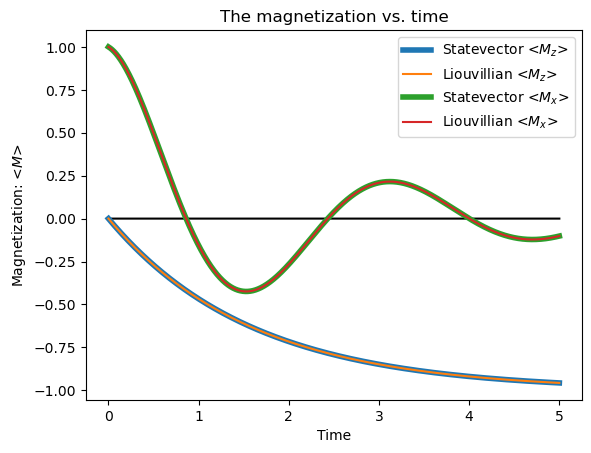

In [1789]:
''' The pure Ising model. '''

times_ = np.linspace(0.0, 5.0, 10*int(1/0.005))

magz = cdict['ZI'] + cdict['IZ']
magx = cdict['XI'] + cdict['IX']

Jz = 1; Jx = 0.5; Jy = 0.5;
H = (Jz) * cdict['ZZ']

Lpm = qutip.liouvillian(H) + l

psi0 = tensor(hadamard_transform()*basis(2, 0),hadamard_transform()*basis(2, 0))

be = np.sqrt(al) # Change this above
# be = 0.62
cops = [be*cdict['DI'], be*cdict['ID']]
result = mesolve(H, psi0.proj(), times_, c_ops=cops, e_ops=[magz, magx])
result_pm = mesolve(Lpm, psi0.proj(), times_, e_ops=[magz, magx])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(result.times, [0 for i in range(len(result.times))], '-k');

ax.plot(result.times, [result.expect[0][i]/nk for i in range(len(result.times))],
       label='Statevector <$M_z$>', linewidth=4);

ax.plot(result_pm.times, [result_pm.expect[0][i]/nk for i in range(len(result_pm.times))],
       label='Liouvillian <$M_z$>');

ax.plot(result.times, [result.expect[1][i]/nk for i in range(len(result.times))],
       label='Statevector <$M_x$>', linewidth=4);

ax.plot(result_pm.times, [result_pm.expect[1][i]/nk for i in range(len(result_pm.times))],
       label='Liouvillian <$M_x$>');

ax.set_xlabel('Time');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization vs. time')

ax.legend();

plt.show(fig)

In [1772]:
with PdfPages(r'amp_damp_exact.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [1799]:
## This is the \sigma_+ \sigma_- part:
nk = 4
lz = 0
al = 0.63
be = 0.45
for n in range(nk):
    c_op_left = expand_operator(sigmam(), nk, n)
    c_op_right = expand_operator(sigmap(), nk, n)
    z_op_left = expand_operator(sigmaz(), nk, n)
    z_op_right = expand_operator(sigmaz(), nk, n)
    lz += al * sprepost(c_op_left, c_op_right)
    lz += be * sprepost(z_op_left, z_op_right)
    both = -0.5 * al * c_op_right * c_op_left
    bothz = -0.5 * be * z_op_right * z_op_left
    lz += spre(both)
    lz += spost(both)
    lz += spre(bothz)
    lz += spost(bothz)

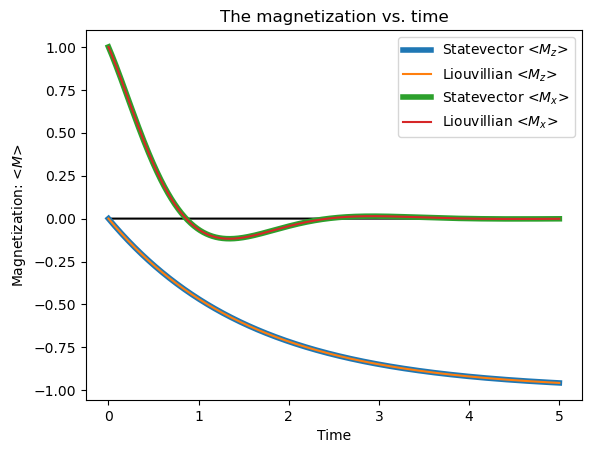

In [1800]:
''' The pure Ising model. '''

times_ = np.linspace(0.0, 5.0, 10*int(1/0.005))

magz = cdict['ZI'] + cdict['IZ']
magx = cdict['XI'] + cdict['IX']

Jz = -1; Jx = 0.5; Jy = 0.5;
H = (Jz) * cdict['ZZ']

Lad = qutip.liouvillian(H) + lz

psi0 = tensor(hadamard_transform()*basis(2, 0),hadamard_transform()*basis(2, 0))

ga = np.sqrt(al)
de = np.sqrt(be)
cops = [ga*cdict['DI'], ga*cdict['ID'], de*cdict['ZI'], de*cdict['IZ']]
result_ = mesolve(H, psi0.proj(), times_, c_ops=cops, e_ops=[magz, magx])
result_ad = mesolve(Lad, psi0.proj(), times_, e_ops=[magz, magx])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(result_.times, [0 for i in range(len(result_.times))], '-k');

ax.plot(result_.times, [result_.expect[0][i]/nk for i in range(len(result_.times))],
       label='Statevector <$M_z$>', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[0][i]/nk for i in range(len(result_ad.times))],
       label='Liouvillian <$M_z$>');

ax.plot(result_.times, [result_.expect[1][i]/nk for i in range(len(result_.times))],
       label='Statevector <$M_x$>', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[1][i]/nk for i in range(len(result_ad.times))],
       label='Liouvillian <$M_x$>');

ax.set_xlabel('Time');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization vs. time')

ax.legend();

plt.show(fig)

In [1319]:
with PdfPages(r'phase_amp_damp_exact.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [1408]:
def trotter_circuit(n, h1 , h2, h3, T, dt):
    
    ''' Make the time evolution circuits (MFIM out to time T). '''

    times = [0] + list(np.linspace(dt * T, T, int(1/dt)))
    
    coup = 2
    
    trot_out = []
    
    for t in times:
    
        qc = QuantumCircuit(int(n))
        
        for i in range(n):
            qc.h(i)
        
        dtt = dt
        # for _ in range(int(t/dt)):
        for _ in range(int(np.round(t/dtt, decimals=3))):
            if not h2 == 0:
                for i in range(int(n)):
                    qc.rx(coup * h2 * dtt, i)
            if not h3 == 0:
                for i in range(int(n)):
                    qc.rz(coup * h3 * dtt, i)
            if not h1 == 0:
                for i in range(1,int(n)-1,2):
                    qc.rzz(coup * h1 * dtt, i, i+1)
                for i in range(0,int(n)-1,2):
                    qc.rzz(coup * h1 * dtt, i, i+1)
            qc.barrier()
        
        qc.measure_all()
        
        trot_out.append(qc)
    
    return trot_out

In [1243]:
def trotter_circuit_x(n, h1 , h2, h3, T, dt):
    
    ''' Make the time evolution circuits (MFIM out to time T). '''

    times = [0] + list(np.linspace(dt * T, T, int(1/dt)))
    
    coup = 2
    
    trot_out = []
    
    for t in times:
    
        qc = QuantumCircuit(int(n))
        
        for i in range(n):
            qc.h(i)
        
        dtt = dt
        # for _ in range(int(t/dt)):
        for _ in range(int(t/dtt)):
            if not h2 == 0:
                for i in range(int(n)):
                    qc.rx(coup * h2 * dtt, i)
            if not h3 == 0:
                for i in range(int(n)):
                    qc.rz(coup * h3 * dtt, i)
            if not h1 == 0:
                for i in range(1,int(n)-1,2):
                    qc.rzz(coup * h1 * dtt, i, i+1)
                for i in range(0,int(n)-1,2):
                    qc.rzz(coup * h1 * dtt, i, i+1)
            qc.barrier()
        
        for i in range(n):
            qc.h(i)
        qc.measure_all()
        
        trot_out.append(qc)
    
    return trot_out

## From here down is circuits

In [1811]:
p_error_1 = 0.01
p_error_2 = 0.001
p_error_3 = 0.001
noise_modelNN = NoiseModel()
noise_modelSZ = NoiseModel()
noise_modelSX = NoiseModel()
noise_modelSZb = NoiseModel()
noise_modelSXb = NoiseModel()

noise_model_PA = NoiseModel()

phase_amp_err = phase_amplitude_damping_error(0.0025, 0.005)

noise_model_PA.add_all_qubit_quantum_error(phase_amp_err, ['rz', 'u1', 'u2', 'u3'])
noise_model_PA.add_all_qubit_quantum_error(phase_amp_err.tensor(phase_amp_err), ['cx'])

noise_model_AD = NoiseModel()

amp_damp_err = amplitude_damping_error(0.0025)

noise_model = NoiseModel().from_backend(FakeQuito())

noise_model_AD.add_all_qubit_quantum_error(amp_damp_err, ['rz', 'u1', 'u2', 'u3'])
noise_model_AD.add_all_qubit_quantum_error(amp_damp_err.tensor(amp_damp_err), ['cx'])

ideal = pauli_error([('X', 0),('I', 1)])
# Include bit flip error (X)
bit_flip = pauli_error([('X', p_error_1), ('I', 1 - p_error_1)])

# Include phase flip error (Z)
phase_flip = pauli_error([('Z', p_error_1), ('I', 1 - p_error_1)])

# Include correlated error as their own error channels
cross_2x = pauli_error([('X', p_error_2), ('I', 1 - p_error_2)])
cross_2y = pauli_error([('Y', p_error_2), ('I', 1 - p_error_2)])
cross_2z = pauli_error([('Z', p_error_2), ('I', 1 - p_error_2)])
cross_2_ = pauli_error([('X', p_error_3), ('Y', p_error_3),
                        ('Z', p_error_3), ('I', 1 - 3*p_error_3)])

# Correlated xx, yy, zz noise -- uses p_error_2
cross_2xx = cross_2x.tensor(cross_2x)
cross_2yy = cross_2y.tensor(cross_2y)
cross_2zz = cross_2z.tensor(cross_2z)

# Compose all the CNOT error:
cross_all = (((cross_2_.tensor(cross_2_)).compose(cross_2xx)
             ).compose(cross_2yy)).compose(cross_2zz)

# Include all error channels in the dephasing noise model (SZ)
noise_modelSZ.add_all_qubit_quantum_error(phase_flip,['u1', 'u2', 'u3'])
noise_modelSZ.add_all_qubit_quantum_error(cross_all,['cx'])
noise_modelSZb.add_all_qubit_quantum_error(phase_flip,['u1', 'u2', 'u3'])

# Same thing as above, but for amp. damp. noise model (SX)
noise_modelSX.add_all_qubit_quantum_error(bit_flip,['u1', 'u2', 'u3'])
noise_modelSX.add_all_qubit_quantum_error(cross_all,['cx'])
noise_modelSXb.add_all_qubit_quantum_error(bit_flip,['u1', 'u2', 'u3'])

In [1717]:
print(noise_model_PA)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'cx', 'u3', 'rz']
  All-qubits errors: ['rz', 'u1', 'u2', 'u3', 'cx']


In [1143]:
device_backend = FakeBelemV2()

In [1144]:
noise_model = NoiseModel.from_backend(device_backend)

/opt/anaconda3/envs/qiskit_env/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:145: UserWarning: When `target` is supplied, `standard_gates` and `warnings` are ignored, and they are always set to true.
  warn("When `target` is supplied, `standard_gates` and `warnings` are ignored,"


In [1812]:
rzzSupOp = Qobj(SuperOp(qczz).data).tidyup(atol=1e-10).full().conj()
rxxSupOp = Qobj(SuperOp(qcxx).data).tidyup(atol=1e-10).full().conj()
ryySupOp = Qobj(SuperOp(qcyy).data).tidyup(atol=1e-10).full().conj()

In [1719]:
Qobj(SuperOp(tqc1).data @ SuperOp(tqc2).data @ SuperOp(tqc3).data) == Qobj(SuperOp(qczz).data)

True

In [709]:
Operator(qc)

Operator([[0.70710678+0.j        , 0.        +0.j        ,
           0.        +0.j        , 0.        -0.70710678j],
          [0.        +0.j        , 0.70710678+0.j        ,
           0.        -0.70710678j, 0.        +0.j        ],
          [0.        +0.j        , 0.        -0.70710678j,
           0.70710678+0.j        , 0.        +0.j        ],
          [0.        -0.70710678j, 0.        +0.j        ,
           0.        +0.j        , 0.70710678+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))

In [460]:
A = noise_model.to_dict()['errors'][15]['instructions']
empty_list = []
for i in range(len(A)):
    c = 0
    for j in A[i][3]['params']:
        c += Qobj(j).dag() * Qobj(j)
    empty_list.append(c)

In [1813]:
''' Run it with QASM. '''

T = 5

nq = 2
    
shots = 8192

# back = Aer.get_backend('aer_simulator', noise_model = noise_model)
# backNN = AerSimulator(noise_model=noise_modelNN)
# backSZ = AerSimulator(noise_model=noise_modelSZ)
# backSX = AerSimulator(noise_model=noise_modelSX)
# backSZb = AerSimulator(noise_model=noise_modelSZb)
# backSXb = AerSimulator(noise_model=noise_modelSXb)
# device_backend = FakeSantiago()
# back = Aer.get_backend('aer_simulator')

back = AerSimulator(noise_model=noise_model)
backPA = AerSimulator(noise_model=noise_model_PA)
backAD = AerSimulator(noise_model=noise_model_AD)

xx = 0.01
# circs = XYZ_trotter(nq, 1, 0.5, 0.5, T, xx)
# circs = trotter_circuit_x(nq, 1, 0, 0, T, xx)
circs = trotter_circuit_x(nq, 1, 0, 0, T, xx)

In [1814]:
''' Continuation of running it: split circs from the noise models. '''

times = np.array([0] + list(np.linspace(xx*T,T,int(1/xx))))
circ_tnoise = [qiskit.transpile(circ, back) for circ in circs]
circ_tnoisePA = [qiskit.transpile(circ, backPA) for circ in circs]
circ_tnoiseAD = [qiskit.transpile(circ, backAD) for circ in circs]

run_circs = qiskit.execute(circ_tnoise, back,
                           shots=shots, initial_layout=[i for i in range(nq)])
run_circsPA = qiskit.execute(circ_tnoisePA, backPA,
                           shots=shots, initial_layout=[i for i in range(nq)])
run_circsAD = qiskit.execute(circ_tnoiseAD, backAD,
                           shots=shots, initial_layout=[i for i in range(nq)])

In [426]:
with open('res_T10_no_noise.pkl', 'wb') as f:
    pkl.dump(run_circsNN.result().get_counts(), f)
    
with open('res_T10_deph_noise.pkl', 'wb') as f:
    pkl.dump(run_circsSZ.result().get_counts(), f)
    
with open('res_T10_ampdamp_noise.pkl', 'wb') as f:
    pkl.dump(run_circsSX.result().get_counts(), f)

In [1815]:
sim_out = run_circs.result()
sim_outPA = run_circsPA.result()
sim_outAD = run_circsAD.result()

In [1642]:
outcomes = [bin(i)[3:] for i in range(2**nq, 2**(nq+1))]

In [1816]:
''' For the case of the noise model (FakeQuito). '''

res = []
for count in sim_out.get_counts():
    ## Process data such that there are no None elements ##
    for string in outcomes:
        if count.get(string) is None:
            count[string] = 0
    ## Expactation value of the MAGNETIZATION ##
    e_val = 0
    for i in range(nq):
        c = 0
        for key in count.keys():
            if int(key[i]) == 0:
                c += count[key]/shots
        e_val += 2 * c - 1
        
    res.append(-e_val/nq)

In [1817]:
''' For the case of phase and amp. damp. noise. '''

resPA = []
for count in sim_outPA.get_counts():
    ## Process data such that there are no None elements ##
    for string in outcomes:
        if count.get(string) is None:
            count[string] = 0
    ## Expactation value of the MAGNETIZATION ##
    e_val = 0
    for i in range(nq):
        c = 0
        for key in count.keys():
            if int(key[i]) == 0:
                c += count[key]/shots
        e_val += 2 * c - 1
        
    resPA.append(e_val/nq)

In [1818]:
''' For the case of solely amp. damp. noise. '''

resAD = []
for count in sim_outAD.get_counts():
    ## Process data such that there are no None elements ##
    for string in outcomes:
        if count.get(string) is None:
            count[string] = 0
    ## Expactation value of the MAGNETIZATION ##
    e_val = 0
    for i in range(nq):
        c = 0
        for key in count.keys():
            if int(key[i]) == 0:
                c += count[key]/shots
        e_val += 2 * c - 1
        
    resAD.append(e_val/nq)

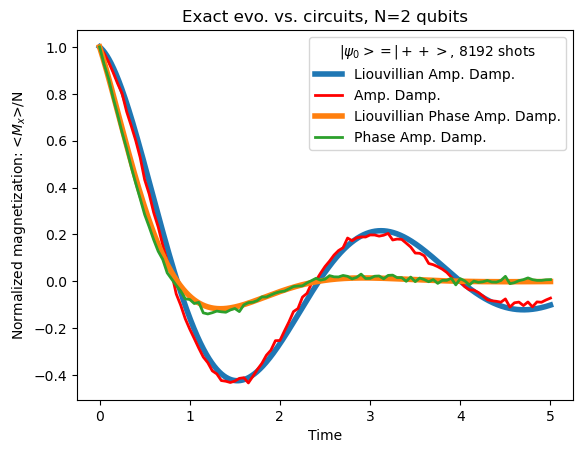

In [1819]:
fig, ax = plt.subplots()

ax.plot(result_pm.times, [result_pm.expect[1][i]/nk for i in range(len(result_pm.times))],
       label='Liouvillian Amp. Damp.', linewidth=4);

ax.plot(times, resAD, '-r', label=r'Amp. Damp.', linewidth=2);

# ax.plot(result_pm.times, [result_pm.expect[0][i]/nk for i in range(len(result_pm.times))],
#        label='Liouvillian Amp. Damp.', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[1][i]/nk for i in range(len(result_ad.times))],
       label='Liouvillian Phase Amp. Damp.', linewidth=4);

ax.plot(times, resPA, label=r'Phase Amp. Damp.', linewidth=2);

# ax.plot(times, res, '-r', label=r'FakeQuito', linewidth=2);

ax.set_xlabel('Time');

ax.set_ylabel('Normalized magnetization: <$M_x$>/N');

ax.set_title('Exact evo. vs. circuits, N=2 qubits')

ax.legend(title=r'$|\psi_0> = |++>$, $8192$ shots');

plt.show()

In [1638]:
with PdfPages(r'liou_v_circ_PAD.pdf') as export_pdf:
    export_pdf.savefig(fig)

## Looking at steady-state solutions of the XYZ model

This is for a 1d system with 4 sites, periodic boundaries.

In [245]:
nq = 4
cdict = {'X0':expand_operator(sigmax(), nq, 0),
         'X1':expand_operator(sigmax(), nq, 1),
         'X2':expand_operator(sigmax(), nq, 2),
         'X3':expand_operator(sigmax(), nq, 3),
         'Z0':expand_operator(sigmaz(), nq, 0),
         'Z1':expand_operator(sigmaz(), nq, 1),
         'Z2':expand_operator(sigmaz(), nq, 2),
         'Z3':expand_operator(sigmaz(), nq, 3),
         'Y0':expand_operator(sigmay(), nq, 0),
         'Y1':expand_operator(sigmay(), nq, 1),
         'Y2':expand_operator(sigmay(), nq, 2),
         'Y3':expand_operator(sigmay(), nq, 3),
         'ZZ01':expand_an_operator(nq, 0, 1, 'Z', 'Z'),
         'ZZ12':expand_an_operator(nq, 1, 2, 'Z', 'Z'),
         'ZZ23':expand_an_operator(nq, 2, 3, 'Z', 'Z'),
         'ZZ03':expand_an_operator(nq, 0, 3, 'Z', 'Z'),
         'XX01':expand_an_operator(nq, 0, 1, 'X', 'X'),
         'XX12':expand_an_operator(nq, 1, 2, 'X', 'X'),
         'XX23':expand_an_operator(nq, 2, 3, 'X', 'X'),
         'XX03':expand_an_operator(nq, 0, 3, 'X', 'X'),
         'YY01':expand_an_operator(nq, 0, 1, 'Y', 'Y'),
         'YY12':expand_an_operator(nq, 1, 2, 'Y', 'Y'),
         'YY23':expand_an_operator(nq, 2, 3, 'Y', 'Y'),
         'YY03':expand_an_operator(nq, 0, 3, 'Y', 'Y'),
         'D0':tensor([destroy(2),qeye(2),qeye(2),qeye(2)]),
         'D1':tensor([qeye(2),destroy(2),qeye(2),qeye(2)]),
         'D2':tensor([qeye(2),qeye(2),destroy(2),qeye(2)]),
         'D3':tensor([qeye(2),qeye(2),qeye(2),destroy(2)])}

This is for 4 sites arranged in a square lattice.

In [28]:
nq = 4
cdict4 = {
    'Z1':expand_operator(sigmaz(), nq, 0), 'Z2':expand_operator(sigmaz(), nq, 1),
    'Z3':expand_operator(sigmaz(), nq, 2), 'Z4':expand_operator(sigmaz(), nq, 3),
    'X1':expand_operator(sigmax(), nq, 0), 'X2':expand_operator(sigmax(), nq, 1),
    'X3':expand_operator(sigmax(), nq, 2), 'X4':expand_operator(sigmax(), nq, 3),
    'Y1':expand_operator(sigmay(), nq, 0), 'Y2':expand_operator(sigmay(), nq, 1),
    'Y3':expand_operator(sigmay(), nq, 2), 'Y4':expand_operator(sigmay(), nq, 3),
    'ZZ12':tensor([sigmaz(),sigmaz(),qeye(2),qeye(2)]),
    'ZZ14':tensor([sigmaz(),qeye(2),qeye(2),sigmaz()]),
    'ZZ23':tensor([qeye(2),sigmaz(),sigmaz(),qeye(2)]),
    'ZZ34':tensor([qeye(2),qeye(2),sigmaz(),sigmaz()]),
    'XX12':tensor([sigmax(),sigmax(),qeye(2),qeye(2)]),
    'XX14':tensor([sigmax(),qeye(2),qeye(2),sigmax()]),
    'XX23':tensor([qeye(2),sigmax(),sigmax(),qeye(2)]),
    'XX34':tensor([qeye(2),qeye(2),sigmax(),sigmax()]),
    'YY12':tensor([sigmay(),sigmay(),qeye(2),qeye(2)]),
    'YY14':tensor([sigmay(),qeye(2),qeye(2),sigmay()]),
    'YY23':tensor([qeye(2),sigmay(),sigmay(),qeye(2)]),
    'YY34':tensor([qeye(2),qeye(2),sigmay(),sigmay()])
}

This is for 6 sites arranged in a square lattice.

In [27]:
nq = 6
cdict6 = {
    'Z1':expand_operator(sigmaz(), nq, 0), 'Z2':expand_operator(sigmaz(), nq, 1),
    'Z3':expand_operator(sigmaz(), nq, 2), 'Z4':expand_operator(sigmaz(), nq, 3),
    'Z5':expand_operator(sigmaz(), nq, 4), 'Z6':expand_operator(sigmaz(), nq, 5),
    'X1':expand_operator(sigmax(), nq, 0), 'X2':expand_operator(sigmax(), nq, 1),
    'X3':expand_operator(sigmax(), nq, 2), 'X4':expand_operator(sigmax(), nq, 3),
    'X5':expand_operator(sigmax(), nq, 4), 'X6':expand_operator(sigmax(), nq, 5),
    'Y1':expand_operator(sigmay(), nq, 0), 'Y2':expand_operator(sigmay(), nq, 1),
    'Y3':expand_operator(sigmay(), nq, 2), 'Y4':expand_operator(sigmay(), nq, 3),
    'Y5':expand_operator(sigmay(), nq, 4), 'Y6':expand_operator(sigmay(), nq, 5),
    'ZZ12':tensor([sigmaz(),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'ZZ14':tensor([sigmaz(),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2)]),
    'ZZ23':tensor([qeye(2),sigmaz(),sigmaz(),qeye(2),qeye(2),qeye(2)]),
    'ZZ34':tensor([qeye(2),qeye(2),sigmaz(),sigmaz(),qeye(2),qeye(2)]),
    'ZZ36':tensor([qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),sigmaz()]),
    'ZZ45':tensor([qeye(2),qeye(2),qeye(2),sigmaz(),sigmaz(),qeye(2)]),
    'ZZ56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),sigmaz()]),
    'XX12':tensor([sigmax(),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'XX14':tensor([sigmax(),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2)]),
    'XX23':tensor([qeye(2),sigmax(),sigmax(),qeye(2),qeye(2),qeye(2)]),
    'XX34':tensor([qeye(2),qeye(2),sigmax(),sigmax(),qeye(2),qeye(2)]),
    'XX36':tensor([qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),sigmax()]),
    'XX45':tensor([qeye(2),qeye(2),qeye(2),sigmax(),sigmax(),qeye(2)]),
    'XX56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),sigmax()]),
    'YY12':tensor([sigmay(),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'YY14':tensor([sigmay(),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2)]),
    'YY23':tensor([qeye(2),sigmay(),sigmay(),qeye(2),qeye(2),qeye(2)]),
    'YY34':tensor([qeye(2),qeye(2),sigmay(),sigmay(),qeye(2),qeye(2)]),
    'YY36':tensor([qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),sigmay()]),
    'YY45':tensor([qeye(2),qeye(2),qeye(2),sigmay(),sigmay(),qeye(2)]),
    'YY56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),sigmay()])
}

Six sites in 1d, include periodic boundaries.

In [474]:
nq = 6
cdict6_1d = {
    'Z1':expand_operator(sigmaz(), nq, 0), 'Z2':expand_operator(sigmaz(), nq, 1),
    'Z3':expand_operator(sigmaz(), nq, 2), 'Z4':expand_operator(sigmaz(), nq, 3),
    'Z5':expand_operator(sigmaz(), nq, 4), 'Z6':expand_operator(sigmaz(), nq, 5),
    'X1':expand_operator(sigmax(), nq, 0), 'X2':expand_operator(sigmax(), nq, 1),
    'X3':expand_operator(sigmax(), nq, 2), 'X4':expand_operator(sigmax(), nq, 3),
    'X5':expand_operator(sigmax(), nq, 4), 'X6':expand_operator(sigmax(), nq, 5),
    'Y1':expand_operator(sigmay(), nq, 0), 'Y2':expand_operator(sigmay(), nq, 1),
    'Y3':expand_operator(sigmay(), nq, 2), 'Y4':expand_operator(sigmay(), nq, 3),
    'Y5':expand_operator(sigmay(), nq, 4), 'Y6':expand_operator(sigmay(), nq, 5),
    'ZZ12':expand_an_operator(nq, 0, 1, 'Z', 'Z'),
    'ZZ23':expand_an_operator(nq, 1, 2, 'Z', 'Z'),
    'ZZ34':expand_an_operator(nq, 2, 3, 'Z', 'Z'),
    'ZZ45':expand_an_operator(nq, 3, 4, 'Z', 'Z'),
    'ZZ56':expand_an_operator(nq, 4, 5, 'Z', 'Z'),
    'ZZ61':expand_an_operator(nq, 0, 5, 'Z', 'Z'),
    'XX12':expand_an_operator(nq, 0, 1, 'X', 'X'),
    'XX23':expand_an_operator(nq, 1, 2, 'X', 'X'),
    'XX34':expand_an_operator(nq, 2, 3, 'X', 'X'),
    'XX45':expand_an_operator(nq, 3, 4, 'X', 'X'),
    'XX56':expand_an_operator(nq, 4, 5, 'X', 'X'),
    'XX61':expand_an_operator(nq, 0, 5, 'X', 'X'),
    'YY12':expand_an_operator(nq, 0, 1, 'Y', 'Y'),
    'YY23':expand_an_operator(nq, 1, 2, 'Y', 'Y'),
    'YY34':expand_an_operator(nq, 2, 3, 'Y', 'Y'),
    'YY45':expand_an_operator(nq, 3, 4, 'Y', 'Y'),
    'YY56':expand_an_operator(nq, 4, 5, 'Y', 'Y'),
    'YY61':expand_an_operator(nq, 0, 5, 'Y', 'Y')
}

This is for 8 sites arranged in a cubic lattice (steadystate is very slow).

In [4]:
nq = 8
cdict8 = {
    'Z1':expand_operator(sigmaz(), nq, 0), 'Z2':expand_operator(sigmaz(), nq, 1),
    'Z3':expand_operator(sigmaz(), nq, 2), 'Z4':expand_operator(sigmaz(), nq, 3),
    'Z5':expand_operator(sigmaz(), nq, 4), 'Z6':expand_operator(sigmaz(), nq, 5),
    'Z7':expand_operator(sigmaz(), nq, 6), 'Z8':expand_operator(sigmaz(), nq, 7),
    'X1':expand_operator(sigmax(), nq, 0), 'X2':expand_operator(sigmax(), nq, 1),
    'X3':expand_operator(sigmax(), nq, 2), 'X4':expand_operator(sigmax(), nq, 3),
    'X5':expand_operator(sigmax(), nq, 4), 'X6':expand_operator(sigmax(), nq, 5),
    'X7':expand_operator(sigmax(), nq, 6), 'X8':expand_operator(sigmax(), nq, 7),
    'Y1':expand_operator(sigmay(), nq, 0), 'Y2':expand_operator(sigmay(), nq, 1),
    'Y3':expand_operator(sigmay(), nq, 2), 'Y4':expand_operator(sigmay(), nq, 3),
    'Y5':expand_operator(sigmay(), nq, 4), 'Y6':expand_operator(sigmay(), nq, 5),
    'Y7':expand_operator(sigmay(), nq, 6), 'Y8':expand_operator(sigmay(), nq, 7),
    'ZZ12':tensor([sigmaz(),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'ZZ14':tensor([sigmaz(),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'ZZ15':tensor([sigmaz(),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2)]),
    'ZZ23':tensor([qeye(2),sigmaz(),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'ZZ26':tensor([qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2)]),
    'ZZ34':tensor([qeye(2),qeye(2),sigmaz(),sigmaz(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'ZZ37':tensor([qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2)]),
    'ZZ48':tensor([qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),qeye(2),sigmaz()]),
    'ZZ56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),sigmaz(),qeye(2),qeye(2)]),
    'ZZ58':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),qeye(2),qeye(2),sigmaz()]),
    'ZZ67':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),sigmaz(),qeye(2)]),
    'ZZ78':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmaz(),sigmaz()]),
    'XX12':tensor([sigmax(),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'XX14':tensor([sigmax(),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'XX15':tensor([sigmax(),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2)]),
    'XX23':tensor([qeye(2),sigmax(),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'XX26':tensor([qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2)]),
    'XX34':tensor([qeye(2),qeye(2),sigmax(),sigmax(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'XX37':tensor([qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2)]),
    'XX48':tensor([qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),qeye(2),sigmax()]),
    'XX56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),sigmax(),qeye(2),qeye(2)]),
    'XX58':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),qeye(2),qeye(2),sigmax()]),
    'XX67':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),sigmax(),qeye(2)]),
    'XX78':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmax(),sigmax()]),
    'YY12':tensor([sigmay(),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'YY14':tensor([sigmay(),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'YY15':tensor([sigmay(),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2)]),
    'YY23':tensor([qeye(2),sigmay(),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'YY26':tensor([qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2)]),
    'YY34':tensor([qeye(2),qeye(2),sigmay(),sigmay(),qeye(2),qeye(2),qeye(2),qeye(2)]),
    'YY37':tensor([qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2)]),
    'YY48':tensor([qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),qeye(2),sigmay()]),
    'YY56':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),sigmay(),qeye(2),qeye(2)]),
    'YY58':tensor([qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),qeye(2),qeye(2),sigmay()]),
    'YY67':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),sigmay(),qeye(2)]),
    'YY78':tensor([qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),qeye(2),sigmay(),sigmay()])
}

In [825]:
## This is the \sigma_+ \sigma_- part:
nk = 6
lz = 0
al = 1
be = 0
for n in range(nk):
    c_op_left = expand_operator(sigmam(), nk, n)
    c_op_right = expand_operator(sigmap(), nk, n)
    z_op_left = expand_operator(sigmaz(), nk, n)
    z_op_right = expand_operator(sigmaz(), nk, n)
    lz += al * sprepost(c_op_left, c_op_right)
    lz += be * sprepost(z_op_left, z_op_right)
    both = -0.5 * al * c_op_right * c_op_left
    bothz = -0.5 * be * z_op_right * z_op_left
    lz += spre(both)
    lz += spost(both)
    lz += spre(bothz)
    lz += spost(bothz)

In [440]:
''' The XYZ model, 4 sites on a square lattice. '''

nk = 4
breaks = 41

# times_ = np.linspace(0.0, 50.0, 50*int(1/0.005))

sdm_1d_4 = []

Jz = 1; Jy = 0; d = 1;
coupling = np.linspace(-4., 4., breaks)
Lad = []
# for i, Jy in enumerate(coupling):
for j, Jx in enumerate(coupling):
    H = ((Jz) * (cdict['ZZ01'] + cdict['ZZ12'] + cdict['ZZ23'] + cdict['ZZ03'])
        + (Jx) * (cdict['XX01'] + cdict['XX12'] + cdict['XX23'] + cdict['XX03'])
        + (Jy) * (cdict['YY01'] + cdict['YY12'] + cdict['YY23'] + cdict['YY03']))/(2*d)

    Lad.append([(i, j), (Jy, Jx), qutip.liouvillian(H) + lz])

In [437]:
''' The XYZ model, 4 sites on a square lattice. '''

nk = 4
breaks = 41

# times_ = np.linspace(0.0, 50.0, 50*int(1/0.005))

sdm_1d_4 = []

Jz = 1; Jy = 0; Jx = 1.5; d = 1;
# coupling = np.linspace(-4., 4., breaks)
Lad = []
H = ((Jz) * (cdict['ZZ01'] + cdict['ZZ12'] + cdict['ZZ23'] + cdict['ZZ03'])
    + (Jx) * (cdict['XX01'] + cdict['XX12'] + cdict['XX23'] + cdict['XX03'])
    + (Jy) * (cdict['YY01'] + cdict['YY12'] + cdict['YY23'] + cdict['YY03']))/(2*d)

Lad.append([(i, j), (Jy, Jx), qutip.liouvillian(H) + lz])

In [438]:
np.abs(np.real(Lad[0][2].eigenenergies()))

array([4.00000000e+00, 3.61075541e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 2.88942560e+00, 2.88664950e+00,
       2.88664950e+00, 2.84535040e+00, 2.84535040e+00, 2.80004436e+00,
       2.77919792e+00, 2.77919792e+00, 2.72613104e+00, 2.71549219e+00,
       2.69458946e+00, 2.69458946e+00, 2.69458946e+00, 2.69458946e+00,
       2.66602976e+00, 2.66602976e+00, 2.60869504e+00, 2.60869504e+00,
       2.60869504e+00, 2.60869504e+00, 2.58919817e+00, 2.58919817e+00,
       2.57143179e+00, 2.56164534e+00, 2.56164534e+00, 2.52880664e+00,
       2.52880664e+00, 2.52880664e+00, 2.52880664e+00, 2.51446892e+00,
       2.51446892e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
       2.50000000e+00, 2.49646487e+00, 2.49646487e+00, 2.49646487e+00,
       2.49646487e+00, 2.46725068e+00, 2.46584410e+00, 2.46584410e+00,
       2.46584410e+00, 2.46584410e+00, 2.44002316e+00, 2.44002316e+00,
      

In [414]:
eig_4p = []
for x, y, z in Lad:
    eig_4p.append([x, y, z.eigenenergies()])

In [429]:
np.abs(np.real(eig_4p[int(len(eig_4p)/2-20)][2]))

array([4.00000000e+00, 3.50000000e+00, 3.50000000e+00, 3.50000000e+00,
       3.50000000e+00, 3.00196075e+00, 3.00196075e+00, 3.00196075e+00,
       3.00196075e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 2.75098038e+00,
       2.75098038e+00, 2.75098038e+00, 2.75098038e+00, 2.75098038e+00,
       2.75098038e+00, 2.75098038e+00, 2.75098038e+00, 2.74901962e+00,
       2.74901962e+00, 2.74901962e+00, 2.74901962e+00, 2.74901962e+00,
       2.74901962e+00, 2.74901962e+00, 2.74901962e+00, 2.70779698e+00,
       2.70779698e+00, 2.50196075e+00, 2.50196075e+00, 2.50196075e+00,
       2.50196075e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00, 2.50000000e+00, 2.50000000e+00,
      

In [415]:
contour_plot_object = []
for x, y, eig in eig_4p:
    contour_plot_object.append([x, y, min([n for n in np.abs(np.real(eig)) if n > 1e-10])])
contour_plot_object = np.array(contour_plot_object, dtype=object).reshape((breaks, 
                                                        breaks*3), order='C')

In [416]:
X = np.zeros((breaks, breaks))
Y = np.zeros((breaks, breaks))
Z = np.zeros((breaks, breaks))

for x in contour_plot_object:
    for (a,b), (c,d), e in zip(x[0::3], x[1::3], x[2::3]):
        X[a,b] = c; Y[a,b] = d; Z[a,b] = e

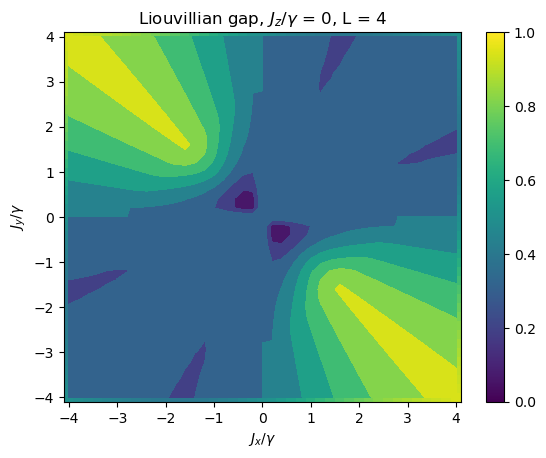

In [418]:
fig, ax = plt.subplots()

pcm = ax.pcolor(X, Y, Z, vmin=0, vmax=1, cmap='viridis')

ax.contourf(X, Y, Z, cmap='viridis')
# ax.plot(coupling, mz, label=r'<$M_z$>', linewidth=2);

ax.set_xlabel('$J_x/\gamma$');

ax.set_ylabel('$J_y/\gamma$');

ax.set_title('Liouvillian gap, $J_z/\gamma$ = 0, L = 4')

plt.colorbar(pcm);

plt.show(fig)

In [419]:
with PdfPages(r'liouvillian_gap_sarang_z0.pdf') as export_pdf:
    export_pdf.savefig(fig)

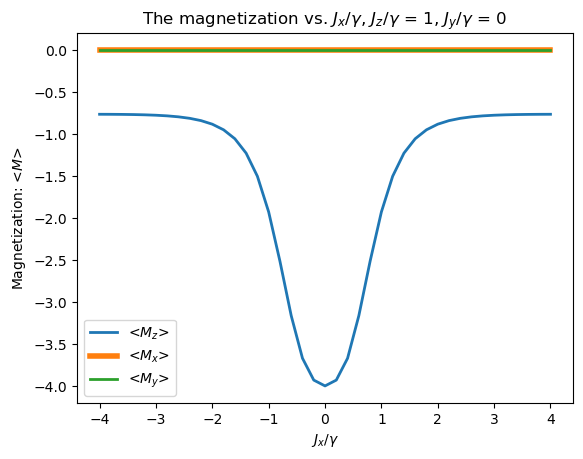

In [267]:
sdm = []
for _, _, ent in Lad[int(len(Lad)/2-20):int(len(Lad)/2+21)]:
    sdm.append(steadystate(ent, None, method='direct'))

magz = sum([cdict[f'Z{n}'] for n in range(nk)])
smagz = sum([(-1)**n * cdict[f'Z{n}'] for n in range(nk)])
magx = sum([cdict[f'X{n}'] for n in range(nk)])
smagx = sum([(-1)**n * cdict[f'X{n}'] for n in range(nk)])
magy = sum([cdict[f'Y{n}'] for n in range(nk)])
smagy = sum([(-1)**n * cdict[f'Y{n}'] for n in range(nk)])

mz = []
smz = []
mx = []
smx = []
my = []
smy = []

for ent in sdm:
    mz.append(np.trace(ent * magz))
    smz.append(np.trace(ent * smagz))
    mx.append(np.trace(ent * magx))
    smx.append(np.trace(ent * smagx))
    my.append(np.trace(ent * magy))
    smy.append(np.trace(ent * smagy))    

fig, ax = plt.subplots()

ax.plot(coupling, mz, label=r'<$M_z$>', linewidth=2);
# ax.plot(coupling, smz, label=r'<s$M_z$>', linewidth=6);
ax.plot(coupling, mx, label=r'<$M_x$>', linewidth=4);
# ax.plot(coupling, smx, label=r'<s$M_x$>', linewidth=2);
ax.plot(coupling, my, label=r'<$M_y$>', linewidth=2);

ax.set_xlabel('$J_x/\gamma$');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization vs. $J_x/\gamma$, $J_z/\gamma$ = 1, $J_y/\gamma$ = 0')

ax.legend();

plt.show(fig)

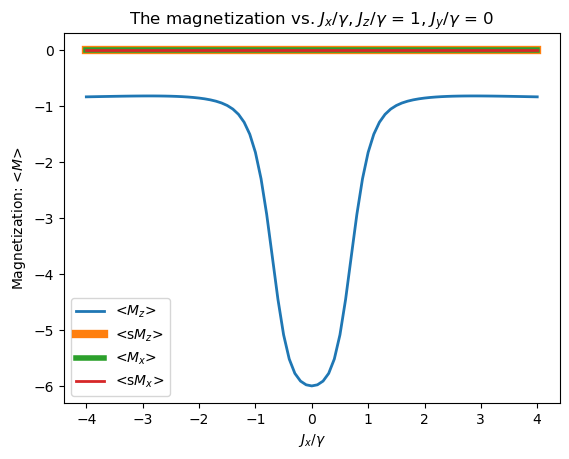

In [31]:
''' The XYZ model, 6 sites on a square lattice. '''

nk = 6

times_ = np.linspace(0.0, 50.0, 50*int(1/0.005))

magz = sum([cdict6[f'Z{n}'] for n in range(1,nk+1)])
smagz = sum([(-1)**n * cdict6[f'Z{n}'] for n in range(1,nk+1)])
magx = sum([cdict6[f'X{n}'] for n in range(1,nk+1)])
smagx = sum([(-1)**n * cdict6[f'X{n}'] for n in range(1,nk+1)])

mz = []
smz = []
mx = []
smx = []
sdm_sq_6 = []
Jz = 1; Jy = 0; d = 2;
coupling = np.linspace(-4., 4., 81)
for Jx in coupling:
    H = ((Jz) * (cdict6['ZZ12'] + cdict6['ZZ14'] + cdict6['ZZ23'] + cdict6['ZZ34']
                + cdict6['ZZ36'] + cdict6['ZZ45'] + cdict6['ZZ56'])
        + (Jx) * (cdict6['XX12'] + cdict6['XX14'] + cdict6['XX23'] + cdict6['XX34']
                 + cdict6['XX36'] + cdict6['XX45'] + cdict6['XX56'])
        + (Jy) * (cdict6['YY12'] + cdict6['YY14'] + cdict6['YY23'] + cdict6['YY34']
                 + cdict6['YY36'] + cdict6['YY45'] + cdict6['YY56']))

    Lad = qutip.liouvillian(H) + lz
    
    # sdm = steadystate(Lad, None, method='direct')
    sdmsq_6.append(steadystate(H, [expand_operator(sigmam(), nk, n) for n in range(nk)],
                      method='direct'))

#     mz.append(np.trace(sdm * magz))
#     smz.append(np.trace(sdm * smagz))
#     mx.append(np.trace(sdm * magx))
#     smx.append(np.trace(sdm * smagx))

fig, ax = plt.subplots()

ax.plot(coupling, mz, label=r'<$M_z$>', linewidth=2);
ax.plot(coupling, smz, label=r'<s$M_z$>', linewidth=6);
ax.plot(coupling, mx, label=r'<$M_x$>', linewidth=4);
ax.plot(coupling, smx, label=r'<s$M_x$>', linewidth=2);

ax.set_xlabel('$J_x/\gamma$');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization vs. $J_x/\gamma$, $J_z/\gamma$ = 1, $J_y/\gamma$ = 0')

ax.legend();

plt.show(fig)

In [451]:
np.linspace(-4., 4., 17)

array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
        1.5,  2. ,  2.5,  3. ,  3.5,  4. ])

In [831]:
''' The XYZ model, 6 sites in 1d w/ periodic bounds. '''

nk = 6

times_ = np.linspace(0.0, 50.0, 50*int(1/0.005))

sdm_1d_6 = []
Jz = 1; Jy = -1.5; d = 1;
coupling = np.linspace(-4., 4., 17)
Lad = []
i = 0
# for i, Jy in enumerate(coupling):
for j, Jx in enumerate(coupling):
    H = ((Jz) * (cdict6_1d['ZZ12'] + cdict6_1d['ZZ23'] + cdict6_1d['ZZ34'] + cdict6_1d['ZZ45']
                + cdict6_1d['ZZ56'] + cdict6_1d['ZZ61'])
        + (Jx) * (cdict6_1d['XX12'] + cdict6_1d['XX23'] + cdict6_1d['XX34'] + cdict6_1d['XX45']
                 + cdict6_1d['XX56'] + cdict6_1d['XX61'])
        + (Jy) * (cdict6_1d['YY12'] + cdict6_1d['YY23'] + cdict6_1d['YY34'] + cdict6_1d['YY45']
                 + cdict6_1d['YY56'] + cdict6_1d['YY61']))/(2*d)

    Lad.append([(i, j), (Jy, Jx), qutip.liouvillian(H) + lz])

for x, y, element in Lad:
    sdm_1d_6.append([x, y, steadystate(element, None, method='direct')])
    # sdm_1d_6.append(steadystate(H, [expand_operator(sigmam(), nk, n) for n in range(nk)],
    #                   method='direct'))

In [221]:
eig_Lad = []
for i, j, k in Lad:
    eig_Lad.append([i, j, k.eigenenergies()])

KeyboardInterrupt: 

In [809]:
''' Make the dictionary of correlations for 6 sites (pbc). '''
nq = 6
corr_dict_6 = {}
for el in ['X', 'Y', 'Z']:
    for i in range(nq):
        for j in range(i+1, nq):
            corr_dict_6[f'{el}{el}{i}{j}'] = expand_an_operator(nq, i, j, el, el)
    for i in range(nq):
        if i < nq-1:
            j = i+1 
        else:
            j = 1
        corr_dict_6[f'{el}{i}'] = expand_an_operator(nq, i, j, el)

In [781]:
len(corr_dict_6)

63

In [832]:
mz = []
smz = []
mx = []
smx = []

magz = sum([cdict6_1d[f'Z{n}'] for n in range(1,nk+1)])
smagz = sum([(-1)**n * cdict6_1d[f'Z{n}'] for n in range(1,nk+1)])
magx = sum([cdict6_1d[f'X{n}'] for n in range(1,nk+1)])
smagx = sum([(-1)**n * cdict6_1d[f'X{n}'] for n in range(1,nk+1)])
# xx_cor = [[] for _ in sdm_1d_6]
xx_cor = []
yy_cor = []
zz_cor = []
# z2 = []
# z2_ = Qobj(qeye(magz.shape[0]), magz.dims)
# for mat in [cdict6_1d[f'Z{n}'] for n in range(1,nk+1)]:
#     z2_ = mat*z2_

for x, y, ent in sdm_1d_6:
#     mz.append(np.trace(ent * magz))
#     smz.append(np.trace(ent * smagz))
#     mx.append(np.trace(ent * magx))
#     smx.append(np.trace(ent * smagx))
#     z2.append(np.trace(ent * z2_))
    for key in corr_dict_6:
        if key[0] == 'X':
            xx_cor.append((x, y, key, np.real(np.trace(ent * corr_dict_6[key]))))
        if key[0] == 'Y':
            yy_cor.append((x, y, key, np.real(np.trace(ent * corr_dict_6[key]))))
        if key[0] == 'Z':
            zz_cor.append((x, y, key, np.real(np.trace(ent * corr_dict_6[key]))))

# fig, ax = plt.subplots()

# ax.plot(coupling, mz, label=r'<$M_z$>', linewidth=2);
# ax.plot(coupling, smz, label=r'<s$M_z$>', linewidth=6);
# ax.plot(coupling, mx, label=r'<$M_x$>', linewidth=4);
# ax.plot(coupling, smx, label=r'<s$M_x$>', linewidth=2);

# ax.set_xlabel('$J_x/\gamma$');

# ax.set_ylabel('Magnetization: <$M$>');

# ax.set_title('The magnetization vs. $J_x/\gamma$, $J_z/\gamma$ = 1, $J_y/\gamma$ = 0')

# ax.legend();

# plt.show(fig)

In [785]:
xx_cor[21:42]

[((0, 1), (1.5, -3.5), 'XX01', -0.0384477611885119),
 ((0, 1), (1.5, -3.5), 'XX02', 0.03943386902472114),
 ((0, 1), (1.5, -3.5), 'XX03', 0.0029427414444780876),
 ((0, 1), (1.5, -3.5), 'XX04', 0.03943386902472124),
 ((0, 1), (1.5, -3.5), 'XX05', -0.038447761188511655),
 ((0, 1), (1.5, -3.5), 'XX12', -0.03844776118851141),
 ((0, 1), (1.5, -3.5), 'XX13', 0.03943386902472099),
 ((0, 1), (1.5, -3.5), 'XX14', 0.002942741444478144),
 ((0, 1), (1.5, -3.5), 'XX15', 0.03943386902472101),
 ((0, 1), (1.5, -3.5), 'XX23', -0.03844776118851187),
 ((0, 1), (1.5, -3.5), 'XX24', 0.039433869024721194),
 ((0, 1), (1.5, -3.5), 'XX25', 0.0029427414444781613),
 ((0, 1), (1.5, -3.5), 'XX34', -0.03844776118851151),
 ((0, 1), (1.5, -3.5), 'XX35', 0.03943386902472151),
 ((0, 1), (1.5, -3.5), 'XX45', -0.038447761188511766),
 ((0, 1), (1.5, -3.5), 'X0', 0.0),
 ((0, 1), (1.5, -3.5), 'X1', 0.0),
 ((0, 1), (1.5, -3.5), 'X2', 0.0),
 ((0, 1), (1.5, -3.5), 'X3', 0.0),
 ((0, 1), (1.5, -3.5), 'X4', 0.0),
 ((0, 1), (1.5, -

In [786]:
yy_cor[0:21]

[((0, 0), (1.5, -4.0), 'YY01', 0.010866337780558953),
 ((0, 0), (1.5, -4.0), 'YY02', 0.012878898453461924),
 ((0, 0), (1.5, -4.0), 'YY03', -0.016490571522342862),
 ((0, 0), (1.5, -4.0), 'YY04', 0.012878898453461862),
 ((0, 0), (1.5, -4.0), 'YY05', 0.010866337780558953),
 ((0, 0), (1.5, -4.0), 'YY12', 0.010866337780558347),
 ((0, 0), (1.5, -4.0), 'YY13', 0.012878898453461683),
 ((0, 0), (1.5, -4.0), 'YY14', -0.01649057152234283),
 ((0, 0), (1.5, -4.0), 'YY15', 0.012878898453461842),
 ((0, 0), (1.5, -4.0), 'YY23', 0.010866337780558788),
 ((0, 0), (1.5, -4.0), 'YY24', 0.012878898453461633),
 ((0, 0), (1.5, -4.0), 'YY25', -0.016490571522342994),
 ((0, 0), (1.5, -4.0), 'YY34', 0.010866337780558934),
 ((0, 0), (1.5, -4.0), 'YY35', 0.012878898453461626),
 ((0, 0), (1.5, -4.0), 'YY45', 0.01086633778055864),
 ((0, 0), (1.5, -4.0), 'Y0', 0.0),
 ((0, 0), (1.5, -4.0), 'Y1', 0.0),
 ((0, 0), (1.5, -4.0), 'Y2', 0.0),
 ((0, 0), (1.5, -4.0), 'Y3', 0.0),
 ((0, 0), (1.5, -4.0), 'Y4', 0.0),
 ((0, 0), (1.5

In [819]:
zz_cor[0:21]

[((0, 0), (0, -4.0), 'ZZ01', 0.07451968171443293),
 ((0, 0), (0, -4.0), 'ZZ02', 0.06094975010493609),
 ((0, 0), (0, -4.0), 'ZZ03', 0.05728701779008527),
 ((0, 0), (0, -4.0), 'ZZ04', 0.060949750104935946),
 ((0, 0), (0, -4.0), 'ZZ05', 0.07451968171443273),
 ((0, 0), (0, -4.0), 'ZZ12', 0.07451968171443295),
 ((0, 0), (0, -4.0), 'ZZ13', 0.06094975010493614),
 ((0, 0), (0, -4.0), 'ZZ14', 0.057287017790085576),
 ((0, 0), (0, -4.0), 'ZZ15', 0.060949750104936216),
 ((0, 0), (0, -4.0), 'ZZ23', 0.0745196817144328),
 ((0, 0), (0, -4.0), 'ZZ24', 0.060949750104935946),
 ((0, 0), (0, -4.0), 'ZZ25', 0.05728701779008535),
 ((0, 0), (0, -4.0), 'ZZ34', 0.07451968171443267),
 ((0, 0), (0, -4.0), 'ZZ35', 0.06094975010493596),
 ((0, 0), (0, -4.0), 'ZZ45', 0.07451968171443271),
 ((0, 0), (0, -4.0), 'Z0', -0.2367905646592751),
 ((0, 0), (0, -4.0), 'Z1', -0.23679056465927553),
 ((0, 0), (0, -4.0), 'Z2', -0.2367905646592752),
 ((0, 0), (0, -4.0), 'Z3', -0.23679056465927478),
 ((0, 0), (0, -4.0), 'Z4', -0.2367

In [621]:
for x, y in zip(coupling, xx_cor):
    if x == 3.0:
        print(x, y)

3.0 ((0, 0), (0, -4.0), 'XX45', -0.016227088294484257)


In [805]:
xx_cor[58:61]

[((0, 2), (1.5, -3.0), 'X1', 0.0),
 ((0, 2), (1.5, -3.0), 'X2', 0.0),
 ((0, 2), (1.5, -3.0), 'X3', 0.0)]

In [833]:
sep = [1, 2, 3]

jxM4_0 = [el - xx_cor[15][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(xx_cor[0:3], xx_cor[16:19])]
jyM4_0 = [el - yy_cor[15][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(yy_cor[0:3], yy_cor[16:19])]
jzM4_0 = [el - zz_cor[15][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(zz_cor[0:3], zz_cor[16:19])]

jxM3_0 = [el - xx_cor[57][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(xx_cor[42:45], xx_cor[58:61])]
jyM3_0 = [el - yy_cor[57][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(yy_cor[42:45], yy_cor[58:61])]
jzM3_0 = [el - zz_cor[57][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(zz_cor[42:45], zz_cor[58:61])]

jxM2_5 = [el - xx_cor[78][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(xx_cor[63:66], xx_cor[79:82])]
jyM2_5 = [el - yy_cor[79][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(yy_cor[63:66], yy_cor[79:82])]
jzM2_5 = [el - zz_cor[79][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(zz_cor[63:66], zz_cor[79:82])]

jxM2_0 = [el - xx_cor[99][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(xx_cor[84:87], xx_cor[100:103])]
jyM2_0 = [el - yy_cor[99][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(yy_cor[84:87], yy_cor[100:103])]
jzM2_0 = [el - zz_cor[99][3]*el0 for (_, _, _, el), (_, _, _, el0) in 
          zip(zz_cor[84:87], zz_cor[100:103])]

jxM1_5 = [el - xx_cor[120][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(xx_cor[105:108], xx_cor[121:124])]
jyM1_5 = [el - yy_cor[120][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(yy_cor[105:108], yy_cor[121:124])]
jzM1_5 = [el - zz_cor[120][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(zz_cor[105:108], zz_cor[121:124])]

jxM1_0 = [el - xx_cor[141][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(xx_cor[126:129], xx_cor[142:145])]
jyM1_0 = [el - yy_cor[141][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(yy_cor[126:129], yy_cor[142:145])]
jzM1_0 = [el - zz_cor[141][3]*el0 for (_, _, _, el), (_, _, _, el0) in
          zip(zz_cor[126:129], zz_cor[142:145])]

jx0_0 = [el - xx_cor[183][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(xx_cor[168:171], xx_cor[184:187])]
jy0_0 = [el - yy_cor[183][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(yy_cor[168:171], yy_cor[184:187])]
jz0_0 = [el - zz_cor[183][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(zz_cor[168:171], zz_cor[184:187])]

jx2_0 = [el - xx_cor[267][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(xx_cor[252:255], xx_cor[268:271])]
jy2_0 = [el - yy_cor[267][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(yy_cor[252:255], yy_cor[268:271])]
jz2_0 = [el - zz_cor[267][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(zz_cor[252:255], zz_cor[268:271])]

jx1_5 = [el - xx_cor[246][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(xx_cor[231:234], xx_cor[247:250])]
jy1_5 = [el - yy_cor[246][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(yy_cor[231:234], yy_cor[247:250])]
jz1_5 = [el - zz_cor[246][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(zz_cor[231:234], zz_cor[247:250])]

jx1_0 = [el - xx_cor[225][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(xx_cor[210:213], xx_cor[226:229])]
jy1_0 = [el - yy_cor[225][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(yy_cor[210:213], yy_cor[226:229])]
jz1_0 = [el - zz_cor[225][3]*el0 for (_, _, _, el), (_, _, _, el0) in
         zip(zz_cor[210:213], zz_cor[226:229])]

# jx2_0 = [xx_cor[60][0][1], xx_cor[60][1][1], xx_cor[60][2][1]]
# jx2_5 = [xx_cor[65][0][1], xx_cor[65][1][1], xx_cor[65][2][1]]
# jx3_0 = [xx_cor[70][0][1], xx_cor[70][1][1], xx_cor[70][2][1]]
# jx3_5 = [xx_cor[75][0][1], xx_cor[75][1][1], xx_cor[75][2][1]]
# jx4_0 = [xx_cor[80][0][1], xx_cor[80][1][1], xx_cor[80][2][1]]

In [795]:
126/21

6.0

In [648]:
sigmam().dag()*sigmam()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

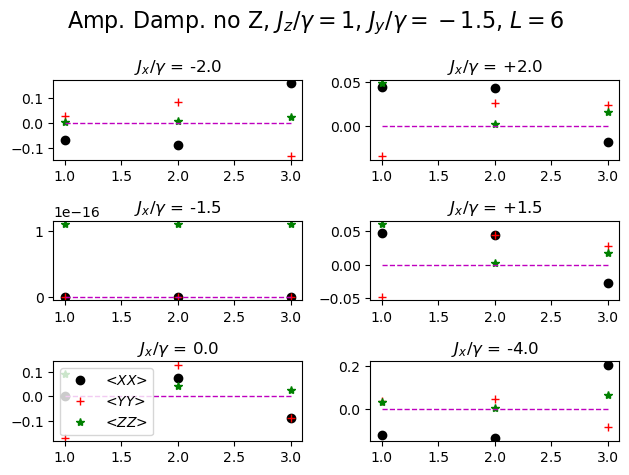

In [834]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(sep, jxM2_0, 'ok', label='<$XX$>', linewidth=4)
ax[0,0].plot(sep, jyM2_0, '+r', label='<$YY$>', linewidth=2)
ax[0,0].plot(sep, jzM2_0, '*g', label='<$ZZ$>', linewidth=1)
ax[0,0].plot(sep, [0, 0, 0], '--m', linewidth=1)

ax[1,0].plot(sep, jxM1_5, 'ok', label='<$XX$>', linewidth=4)
ax[1,0].plot(sep, jyM1_5, '+r', label='<$YY$>', linewidth=2)
ax[1,0].plot(sep, jzM1_5, '*g', label='<$ZZ$>', linewidth=1)
ax[1,0].plot(sep, [0, 0, 0], '--m', linewidth=1)

ax[2,0].plot(sep, jx0_0, 'ok', label='<$XX$>', linewidth=4)
ax[2,0].plot(sep, jy0_0, '+r', label='<$YY$>', linewidth=2)
ax[2,0].plot(sep, jz0_0, '*g', label='<$ZZ$>', linewidth=1)
ax[2,0].plot(sep, [0, 0, 0], '--m', linewidth=1)

ax[0,1].plot(sep, jx2_0, 'ok', label='<$XX$>', linewidth=4)
ax[0,1].plot(sep, jy2_0, '+r', label='<$YY$>', linewidth=2)
ax[0,1].plot(sep, jz2_0, '*g', label='<$ZZ$>', linewidth=1)
ax[0,1].plot(sep, [0, 0, 0], '--m', linewidth=1)

ax[1,1].plot(sep, jx1_5, 'ok', label='<$XX$>', linewidth=4)
ax[1,1].plot(sep, jy1_5, '+r', label='<$YY$>', linewidth=2)
ax[1,1].plot(sep, jz1_5, '*g', label='<$ZZ$>', linewidth=1)
ax[1,1].plot(sep, [0, 0, 0], '--m', linewidth=1)

# ax[2,1].plot(sep, jx1_0, 'ok', label='<$XX$>', linewidth=4)
# ax[2,1].plot(sep, jy1_0, '+r', label='<$YY$>', linewidth=2)
# ax[2,1].plot(sep, jz1_0, '*g', label='<$ZZ$>', linewidth=1)
# ax[2,1].plot(sep, [0, 0, 0], '--m', linewidth=1)

ax[2,1].plot(sep, jxM4_0, 'ok', label='<$XX$>', linewidth=4)
ax[2,1].plot(sep, jyM4_0, '+r', label='<$YY$>', linewidth=2)
ax[2,1].plot(sep, jzM4_0, '*g', label='<$ZZ$>', linewidth=1)
ax[2,1].plot(sep, [0, 0, 0], '--m', linewidth=1)

# ax.set_xlabel('Site separation'); #$J_x/\gamma$

# ax[2,0].set_xlabel('Site Separation'); #<$\prod_i~Z_i$>
# ax[2,1].set_xlabel('Site Separation'); #<$\prod_i~Z_i$>

ax[0,0].set_title('$J_x/\gamma$ = -2.0')
ax[1,0].set_title('$J_x/\gamma$ = -1.5')
ax[2,0].set_title('$J_x/\gamma$ = 0.0')
ax[0,1].set_title('$J_x/\gamma$ = +2.0')
ax[1,1].set_title('$J_x/\gamma$ = +1.5')
ax[2,1].set_title('$J_x/\gamma$ = -4.0')

ax[2,0].legend();

fig.suptitle('Amp. Damp. no Z, $J_z/\gamma = 1$, $J_y/\gamma = -1.5$, $L = 6$', fontsize=16)

plt.tight_layout()

plt.show(fig)

In [835]:
with PdfPages(r'connected_correlations_pm_wJy.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [766]:
# a = hadamard_transform(1)
a = 1
cops = [expand_an_operator(2, 0, 1, 'D', 'I'), expand_an_operator(2, 0, 1, 'I', 'D')]
# cops = None
xx = 1; yy = 0; zz = 1;
test_object = mesolve(xx*expand_an_operator(2, 0, 1, 'X', 'X') + 
                      yy*expand_an_operator(2, 0, 1, 'Y', 'Y') +
                      zz*expand_an_operator(2, 0, 1, 'Z', 'Z'), 
            tensor([a*basis(2,0),a*basis(2,0)]), 
        list(np.linspace(0, 1000, 10001)), cops)

In [767]:
test_object.states[-1].tidyup(atol=1e-8)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.1999998 +0.j         0.        +0.j         0.        +0.j
  0.        -0.20000003j]
 [0.        +0.j         0.19999993+0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.19999993+0.j
  0.        +0.j        ]
 [0.        +0.20000003j 0.        +0.j         0.        +0.j
  0.40000033+0.j        ]]

In [750]:
(test_object.states[-1]*expand_an_operator(2, 0, 1, 'Z', 'I')).tr()

-0.10000055190774251

In [13]:
Jz = 1; Jx = 2; Jy = 0; d = 3
H = ((Jz) * (cdict4['ZZ12'] + cdict4['ZZ14'] + cdict4['ZZ23'] + cdict4['ZZ34'])
        + (Jx) * (cdict4['XX12'] + cdict4['XX14'] + cdict4['XX23'] + cdict4['XX34'])
        + (Jy) * (cdict4['YY12'] + cdict4['YY14'] + cdict4['YY23'] + cdict4['YY34']))/(2*d)

In [14]:
Lad = liouvillian(H) + lz

In [15]:
START = timer()
steadystate(Lad, None, method='direct')
print(timer() - START)

0.005506753999952707


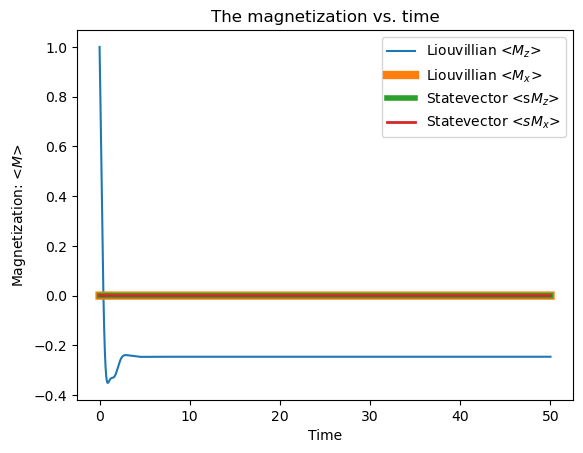

In [1933]:
''' The XYZ model, 8 sites on a cubic lattice. '''

times_ = np.linspace(0.0, 50.0, 50*int(1/0.005))

magz = sum([cdict8[f'Z{n}'] for n in range(1,nk+1)])
smagz = sum([(-1)**n * cdict8[f'Z{n}'] for n in range(1,nk+1)])
magx = sum([cdict8[f'X{n}'] for n in range(1,nk+1)])
smagx = sum([(-1)**n * cdict8[f'X{n}'] for n in range(1,nk+1)])

Jz = 1; Jx = 5; Jy = 0; d = 3;
H = ((Jz) * (cdict8['ZZ12'] + cdict8['ZZ14'] + cdict8['ZZ15'] + cdict8['ZZ23']
            + cdict8['ZZ26'] + cdict8['ZZ34'] + cdict8['ZZ37'] + cdict8['ZZ48']
            + cdict8['ZZ56'] + cdict8['ZZ58'] + cdict8['ZZ67'] + cdict8['ZZ78'])
    + (Jx) * (cdict8['XX12'] + cdict8['XX14'] + cdict8['XX15'] + cdict8['XX23']
            + cdict8['XX26'] + cdict8['XX34'] + cdict8['XX37'] + cdict8['XX48']
            + cdict8['XX56'] + cdict8['XX58'] + cdict8['XX67'] + cdict8['XX78'])
    + (Jy) * (cdict8['YY12'] + cdict8['YY14'] + cdict8['YY15'] + cdict8['YY23']
            + cdict8['YY26'] + cdict8['YY34'] + cdict8['YY37'] + cdict8['YY48']
            + cdict8['YY56'] + cdict8['YY58'] + cdict8['YY67'] + cdict8['YY78']))/(2*d)

Lad = qutip.liouvillian(H) + lz

psi0x = tensor([hadamard_transform()*basis(2, 0) for _ in range(nk)])
psi0z = tensor([basis(2, 0) for _ in range(nk)])

ga = np.sqrt(al)
de = np.sqrt(be)
# cops = [ga*cdict['DI'], ga*cdict['ID'], de*cdict['ZI'], de*cdict['IZ']]
# result_ = mesolve(H, psi0x.proj(), times_, c_ops=cops, e_ops=[magz, magx, smagz, smagx])
# result_ad = mesolve(Lad, psi0z.proj(), times_, e_ops=[magz, magx, smagz, smagx])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

sdm = steadystate(Lad, None, method='direct')

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

np.trace(steadystate(Lad, None, method='direct') * smagz)

fig, ax = plt.subplots()

ax.plot(result_ad.times, [0 for i in range(len(result_ad.times))], '-k');

# ax.plot(result_.times, [result_.expect[0][i]/nk for i in range(len(result_.times))],
#        label='Statevector <$M_z$>', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[0][i]/nk for i in range(len(result_ad.times))],
       label='Liouvillian <$M_z$>');

# ax.plot(result_.times, [result_.expect[1][i]/nk for i in range(len(result_.times))],
#        label='Statevector <$M_x$>', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[1][i]/nk for i in range(len(result_ad.times))],
       label='Liouvillian <$M_x$>', linewidth=6);

ax.plot(result_ad.times, [result_ad.expect[2][i]/nk for i in range(len(result_ad.times))],
       label='Statevector <s$M_z$>', linewidth=4);

ax.plot(result_ad.times, [result_ad.expect[3][i]/nk for i in range(len(result_ad.times))],
       label='Statevector <$sM_x$>', linewidth=2);

ax.set_xlabel('Time');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization vs. time')

ax.legend();

plt.show(fig)

## This is all old stuff

In [4]:
nq = 4
cdict = {'XIII':expand_operator(sigmax(), nq, 0),
         'IXII':expand_operator(sigmax(), nq, 1),
         'IIXI':expand_operator(sigmax(), nq, 2),
         'IIIX':expand_operator(sigmax(), nq, 3),
         'ZIII':expand_operator(sigmaz(), nq, 0),
         'IZII':expand_operator(sigmaz(), nq, 1),
         'IIZI':expand_operator(sigmaz(), nq, 2),
         'IIIZ':expand_operator(sigmaz(), nq, 3),
         'YIII':expand_operator(sigmay(), nq, 0),
         'IYII':expand_operator(sigmay(), nq, 1),
         'IIYI':expand_operator(sigmay(), nq, 2),
         'IIIY':expand_operator(sigmay(), nq, 3),
         'ZZII':tensor([sigmaz(),sigmaz(),qeye(2),qeye(2)]),
         'IZZI':tensor([qeye(2),sigmaz(),sigmaz(),qeye(2)]),
         'IIZZ':tensor([qeye(2),qeye(2),sigmaz(),sigmaz()]),
         'XXII':tensor([sigmax(),sigmax(),qeye(2),qeye(2)]),
         'IXXI':tensor([qeye(2),sigmax(),sigmax(),qeye(2)]),
         'IIXX':tensor([qeye(2),qeye(2),sigmax(),sigmax()]),
         'YYII':tensor([sigmay(),sigmay(),qeye(2),qeye(2)]),
         'IYYI':tensor([qeye(2),sigmay(),sigmay(),qeye(2)]),
         'IIYY':tensor([qeye(2),qeye(2),sigmay(),sigmay()]),
         'DIII':tensor([destroy(2),qeye(2),qeye(2),qeye(2)]),
         'IDII':tensor([qeye(2),destroy(2),qeye(2),qeye(2)]),
         'IIDI':tensor([qeye(2),qeye(2),destroy(2),qeye(2)]),
         'IIID':tensor([qeye(2),qeye(2),qeye(2),destroy(2)]),
         'XYII':tensor([sigmax(),sigmay(),qeye(2),qeye(2)]),
         'IXYI':tensor([qeye(2),sigmax(),sigmay(),qeye(2)]),
         'IIXY':tensor([qeye(2),qeye(2),sigmax(),sigmay()]),
         'XZII':tensor([sigmax(),sigmaz(),qeye(2),qeye(2)]),
         'IXZI':tensor([qeye(2),sigmax(),sigmaz(),qeye(2)]),
         'IIXZ':tensor([qeye(2),qeye(2),sigmax(),sigmaz()]),
         'YXII':tensor([sigmay(),sigmax(),qeye(2),qeye(2)]),
         'IYXI':tensor([qeye(2),sigmay(),sigmax(),qeye(2)]),
         'IIYX':tensor([qeye(2),qeye(2),sigmay(),sigmax()]),
         'YZII':tensor([sigmay(),sigmaz(),qeye(2),qeye(2)]),
         'IYZI':tensor([qeye(2),sigmay(),sigmaz(),qeye(2)]),
         'IIYZ':tensor([qeye(2),qeye(2),sigmay(),sigmaz()]),
         'ZXII':tensor([sigmaz(),sigmax(),qeye(2),qeye(2)]),
         'IZXI':tensor([qeye(2),sigmaz(),sigmax(),qeye(2)]),
         'IIZX':tensor([qeye(2),qeye(2),sigmaz(),sigmax()]),
         'ZYII':tensor([sigmaz(),sigmay(),qeye(2),qeye(2)]),
         'IZYI':tensor([qeye(2),sigmaz(),sigmay(),qeye(2)]),
         'IIZY':tensor([qeye(2),qeye(2),sigmaz(),sigmay()])}

In [5]:
(sigmax()-1j*sigmay())/2 == sigmam()

True

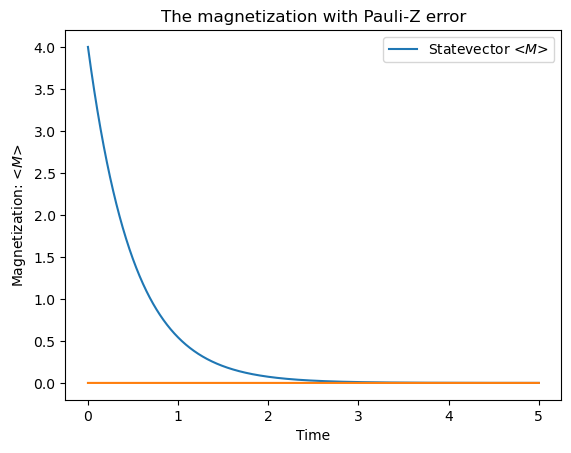

In [801]:
''' The XYZ model. '''

times_ = np.linspace(0.0, 5.0, 10*int(1/0.005))

mag = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
stagMag = (-cdict['ZIII'] + cdict['IZII'] - cdict['IIZI'] + cdict['IIIZ'])*(-1)

Jz = 1; Jx = 0.5; Jy = 0.5;
H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
        (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

psi0 = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
cops = [cdict['XIII'], cdict['IXII'], cdict['IIXI'], cdict['IIIX']]
result = mesolve(H, psi0.proj(), times_, c_ops=cops, e_ops=[mag])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(result.times, [result.expect[0][i] for i in range(len(result.times))],
       label='Statevector <$M$>');

ax.plot(result.times, [0 for i in range(len(result.times))]);

ax.set_xlabel('Time');

ax.set_ylabel('Magnetization: <$M$>');

ax.set_title('The magnetization with Pauli-Z error')

ax.legend();

plt.show(fig)

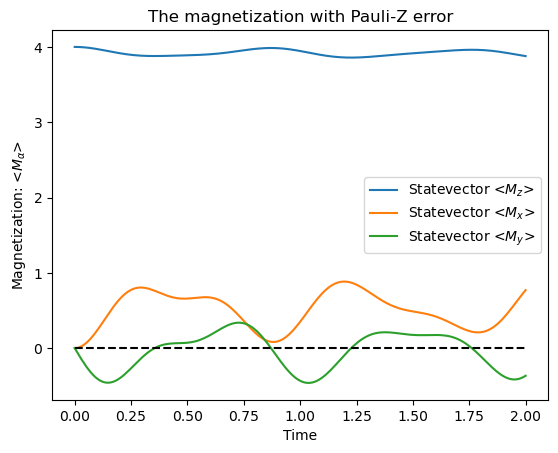

In [202]:
''' The 4 qubit version. Unitary dynamics. '''

times_ = np.linspace(0.0, 2.0, int(1/0.005))

magz = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
magx = cdict['XIII'] + cdict['IXII'] + cdict['IIXI'] + cdict['IIIX']
magy = cdict['YIII'] + cdict['IYII'] + cdict['IIYI'] + cdict['IIIY']
stagMag = -cdict['ZIII'] + cdict['IZII'] - cdict['IIZI'] + cdict['IIIZ']

# Jz = 1; Jx = 0.5; Jy = 0.5;
# H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
#         (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

Jz, hx, hz = 1*np.pi, 0.2*np.pi, 0.2*np.pi;
H = Jz*sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        hx*sum([cdict['XIII'],cdict['IXII'],cdict['IIXI'],cdict['IIIX']]) + \
        hz*sum([cdict['ZIII'],cdict['IZII'],cdict['IIZI'],cdict['IIIZ']])

psi0z = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))
psi0x = hadamard_transform(4)*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
# cops = [cdict['ZIII'], cdict['IZII'], cdict['IIZI'], cdict['IIIZ']]
result = mesolve(H, psi0z.proj(), times_, e_ops=[magz, magx, magy])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(result.times, [result.expect[0][i] for i in range(len(result.times))],
       label='Statevector <$M_z$>');
ax.plot(result.times, [result.expect[1][i] for i in range(len(result.times))],
       label='Statevector <$M_x$>');
ax.plot(result.times, [result.expect[2][i] for i in range(len(result.times))],
       label='Statevector <$M_y$>');

ax.plot(result.times, [0 for i in range(len(result.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-Z error')

ax.legend();

plt.show(fig)

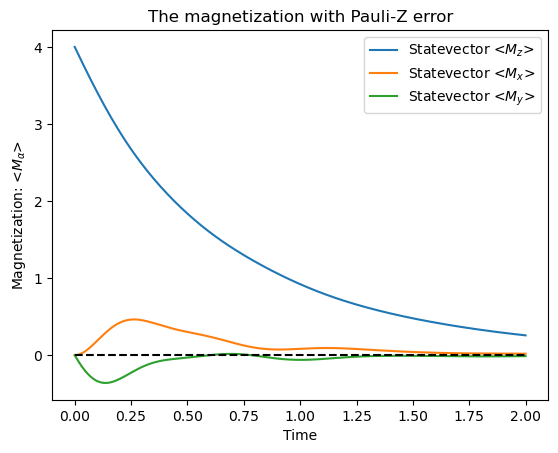

In [297]:
''' The 4 qubit version. All dephasing noise. '''

times_ = np.linspace(0.0, 2.0, int(1/0.005))

magz = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
magx = cdict['XIII'] + cdict['IXII'] + cdict['IIXI'] + cdict['IIIX']
magy = cdict['YIII'] + cdict['IYII'] + cdict['IIYI'] + cdict['IIIY']

# Jz = 1; Jx = 0.5; Jy = 0.5;
# H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
#         (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

Jz, hx, hz = 1*np.pi, 0.2*np.pi, 0.2*np.pi;
H = Jz*sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        hx*sum([cdict['XIII'],cdict['IXII'],cdict['IIXI'],cdict['IIIX']]) + \
        hz*sum([cdict['ZIII'],cdict['IZII'],cdict['IIZI'],cdict['IIIZ']])

#         np.pi * (-0.75) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         np.pi * (-1.33) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

psi0z = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))
psi0x = hadamard_transform(4)*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
cops = [cdict['ZIII'], cdict['IZII'], cdict['IIZI'], cdict['IIIZ'],
        cdict['XXII'], cdict['IXXI'], cdict['IIXX'],
        cdict['YYII'], cdict['IYYI'], cdict['IIYY'],
        cdict['ZZII'], cdict['IZZI'], cdict['IIZZ'],
        cdict['XYII'], cdict['IXYI'], cdict['IIXY'],
        cdict['YXII'], cdict['IYXI'], cdict['IIYX'],
        cdict['ZXII'], cdict['IZXI'], cdict['IIZX'],
        cdict['XZII'], cdict['IXZI'], cdict['IIXZ']]
# coefs = [1 for _ in range(len(cops))]
a1, a2, a3 = 0.7, 0.32, 0.32
coefs = [a1, a1, a1, a1, a2, a2, a2, a2, a2, a2, a2, a2, a2,
         a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3]
resultC = mesolve(H, psi0z.proj(), times_, c_ops=[a*op for a,op in zip(coefs,cops)]
                  , e_ops=[magz, magx, magy])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(result.times, [resultC.expect[0][i] for i in range(len(resultC.times))],
       label='Statevector <$M_z$>');
ax.plot(result.times, [resultC.expect[1][i] for i in range(len(resultC.times))],
       label='Statevector <$M_x$>');
ax.plot(result.times, [resultC.expect[2][i] for i in range(len(resultC.times))],
       label='Statevector <$M_y$>');

ax.plot(resultC.times, [0 for i in range(len(resultC.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-Z error')

ax.legend();

plt.show(fig)

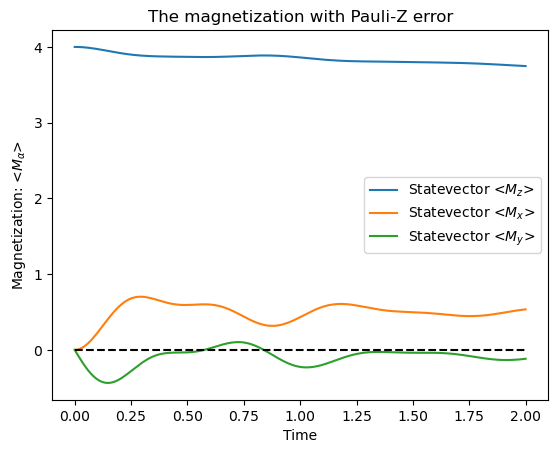

In [239]:
''' The 4 qubit version. All dephasing noise. '''

times_ = np.linspace(0.0, 2.0, int(1/0.005))

magz = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
magx = cdict['XIII'] + cdict['IXII'] + cdict['IIXI'] + cdict['IIIX']
magy = cdict['YIII'] + cdict['IYII'] + cdict['IIYI'] + cdict['IIIY']

# Jz = 1; Jx = 0.5; Jy = 0.5;
# H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
#         (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

Jz, hx, hz = 1*np.pi, 0.2*np.pi, 0.2*np.pi;
H = Jz*sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        hx*sum([cdict['XIII'],cdict['IXII'],cdict['IIXI'],cdict['IIIX']]) + \
        hz*sum([cdict['ZIII'],cdict['IZII'],cdict['IIZI'],cdict['IIIZ']])

#         np.pi * (-0.75) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         np.pi * (-1.33) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

psi0z = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))
psi0x = hadamard_transform(4)*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
cops = [cdict['ZIII'], cdict['IZII'], cdict['IIZI'], cdict['IIIZ'],
#         cdict['XXII'], cdict['IXXI'], cdict['IIXX'],
#         cdict['YYII'], cdict['IYYI'], cdict['IIYY'],
#         cdict['ZZII'], cdict['IZZI'], cdict['IIZZ'],
        cdict['XYII'], cdict['IXYI'], cdict['IIXY'],
        cdict['YXII'], cdict['IYXI'], cdict['IIYX'],
        cdict['ZXII'], cdict['IZXI'], cdict['IIZX'],
        cdict['XZII'], cdict['IXZI'], cdict['IIXZ']]
# coefs = [1 for _ in range(len(cops))]
a1, a2, a3 = 0.7, 0.0, 0.0
coefs = [a1, a1, a1, a1, a2, a2, a2, a2, a2, a2, a2, a2, a2,
         a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3]
resultCb = mesolve(H, psi0z.proj(), times_, c_ops=[a*op for a,op in zip(coefs,cops)]
                  , e_ops=[magz, magx, magy])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(resultCb.times, [resultCb.expect[0][i] for i in range(len(resultCb.times))],
       label='Statevector <$M_z$>');
ax.plot(resultCb.times, [resultCb.expect[1][i] for i in range(len(resultCb.times))],
       label='Statevector <$M_x$>');
ax.plot(resultCb.times, [resultCb.expect[2][i] for i in range(len(resultCb.times))],
       label='Statevector <$M_y$>');

ax.plot(resultCb.times, [0 for i in range(len(resultCb.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-Z error')

ax.legend();

plt.show(fig)

In [809]:
rho_ss = steadystate(H, [cdict['XIII'], cdict['IXII'], cdict['IIXI'], cdict['IIIX']],
                     method='iterative-lgmres')

In [810]:
rho_ss

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[0.0625 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.0625 0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0625 0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0625 0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0625 0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0625 0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0625 0.     0.     0.
  0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0625 0.     0.
  0.     0.     0.     0.     0

In [521]:
np.trace(mag * rho_ss)

(-7.107958666097147e-11+0j)

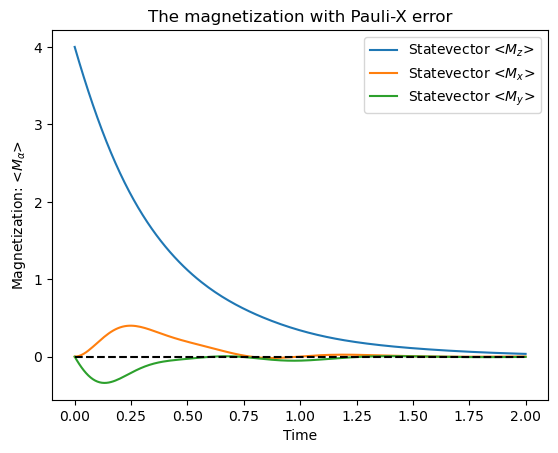

In [296]:
''' The 4 qubit version. All amp. damp. noise. '''

times_ = np.linspace(0.0, 2.0, int(1/0.005))

magz = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
magx = cdict['XIII'] + cdict['IXII'] + cdict['IIXI'] + cdict['IIIX']
magy = cdict['YIII'] + cdict['IYII'] + cdict['IIYI'] + cdict['IIIY']

# Jz = 1; Jx = 0.5; Jy = 0.5;
# H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
#         (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

Jz, hx, hz = 1*np.pi, 0.2*np.pi, 0.2*np.pi;
H = Jz*sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        hx*sum([cdict['XIII'],cdict['IXII'],cdict['IIXI'],cdict['IIIX']]) + \
        hz*sum([cdict['ZIII'],cdict['IZII'],cdict['IIZI'],cdict['IIIZ']])

psi0z = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))
psi0x = hadamard_transform(4)*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
cops = [cdict['XIII'], cdict['IXII'], cdict['IIXI'], cdict['IIIX'],
        cdict['XXII'], cdict['IXXI'], cdict['IIXX'],
        cdict['YYII'], cdict['IYYI'], cdict['IIYY'],
        cdict['ZZII'], cdict['IZZI'], cdict['IIZZ'],
        cdict['XYII'], cdict['IXYI'], cdict['IIXY'],
        cdict['YXII'], cdict['IYXI'], cdict['IIYX'],
        cdict['ZXII'], cdict['IZXI'], cdict['IIZX'],
        cdict['XZII'], cdict['IXZI'], cdict['IIXZ']]
# coefs = [1 for _ in range(len(cops))]
a1, a2, a3 = 0.7, 0.32, 0.32
coefs = [a1, a1, a1, a1, a2, a2, a2, a2, a2, a2, a2, a2, a2,
         a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3]
resultD = mesolve(H, psi0z.proj(), times_, c_ops=[a*op for a,op in zip(coefs,cops)]
                  , e_ops=[magz, magx, magy])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(resultD.times, [resultD.expect[0][i] for i in range(len(resultD.times))],
       label='Statevector <$M_z$>');
ax.plot(resultD.times, [resultD.expect[1][i] for i in range(len(resultD.times))],
       label='Statevector <$M_x$>');
ax.plot(resultD.times, [resultD.expect[2][i] for i in range(len(resultD.times))],
       label='Statevector <$M_y$>');

ax.plot(resultD.times, [0 for i in range(len(resultD.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-X error')

ax.legend();

plt.show(fig)

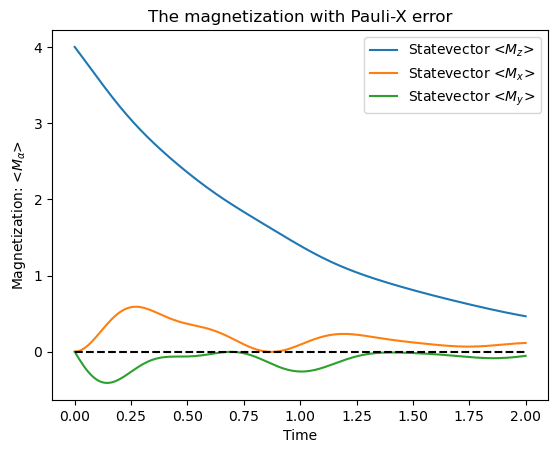

In [243]:
''' The 4 qubit version. All amp. damp. noise. '''

times_ = np.linspace(0.0, 2.0, int(1/0.005))

magz = cdict['ZIII'] + cdict['IZII'] + cdict['IIZI'] + cdict['IIIZ']
magx = cdict['XIII'] + cdict['IXII'] + cdict['IIXI'] + cdict['IIIX']
magy = cdict['YIII'] + cdict['IYII'] + cdict['IIYI'] + cdict['IIIY']

# Jz = 1; Jx = 0.5; Jy = 0.5;
# H = (Jz) * sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
#         (Jx) * sum([cdict['XXII'],cdict['IXXI'],cdict['IIXX']]) + \
#         (Jy) * sum([cdict['YYII'],cdict['IYYI'],cdict['IIYY']])

Jz, hx, hz = 1*np.pi, 0.2*np.pi, 0.2*np.pi;
H = Jz*sum([cdict['ZZII'],cdict['IZZI'],cdict['IIZZ']]) + \
        hx*sum([cdict['XIII'],cdict['IXII'],cdict['IIXI'],cdict['IIIX']]) + \
        hz*sum([cdict['ZIII'],cdict['IZII'],cdict['IIZI'],cdict['IIIZ']])

psi0z = tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))
psi0x = hadamard_transform(4)*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))

# al = 0.38
# be = 0.62
cops = [cdict['XIII'], cdict['IXII'], cdict['IIXI'], cdict['IIIX'],
        cdict['XXII'], cdict['IXXI'], cdict['IIXX'],
        cdict['YYII'], cdict['IYYI'], cdict['IIYY'],
        cdict['ZZII'], cdict['IZZI'], cdict['IIZZ'],
        cdict['XYII'], cdict['IXYI'], cdict['IIXY'],
        cdict['YXII'], cdict['IYXI'], cdict['IIYX'],
        cdict['ZXII'], cdict['IZXI'], cdict['IIZX'],
        cdict['XZII'], cdict['IXZI'], cdict['IIXZ']]
# coefs = [1 for _ in range(len(cops))]
a1, a2, a3 = 0.7, 0.0, 0.0
coefs = [a1, a1, a1, a1, a2, a2, a2, a2, a2, a2, a2, a2, a2,
         a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3, a3]
resultDb = mesolve(H, psi0z.proj(), times_, c_ops=[a*op for a,op in zip(coefs,cops)]
                  , e_ops=[magz, magx, magy])
# result = mesolve(H, psi0, times, [al*qeye(2), be*sigmax()], [sigmaz()])

# out = [np.trace(mag * result.states[i]) for i in range(len(result.states))]

fig, ax = plt.subplots()

ax.plot(resultDb.times, [resultDb.expect[0][i] for i in range(len(resultDb.times))],
       label='Statevector <$M_z$>');
ax.plot(resultDb.times, [resultDb.expect[1][i] for i in range(len(resultDb.times))],
       label='Statevector <$M_x$>');
ax.plot(resultDb.times, [resultDb.expect[2][i] for i in range(len(resultDb.times))],
       label='Statevector <$M_y$>');

ax.plot(resultDb.times, [0 for i in range(len(resultDb.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-X error')

ax.legend();

plt.show(fig)

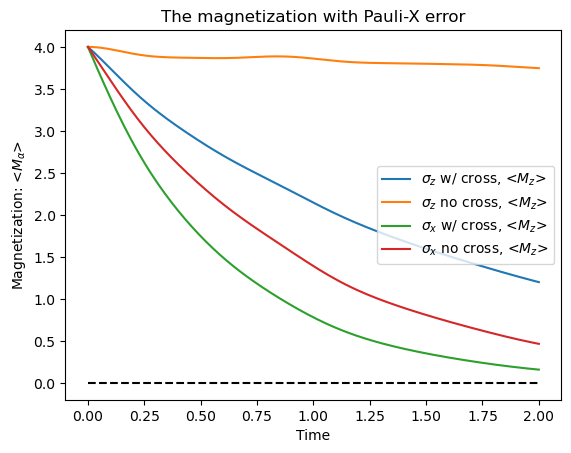

In [244]:
fig, ax = plt.subplots()

ax.plot(resultC.times, [resultC.expect[0][i] for i in range(len(resultC.times))],
       label=r'$\sigma_z$ w/ cross, <$M_z$>');
ax.plot(resultCb.times, [resultCb.expect[0][i] for i in range(len(resultCb.times))],
       label=r'$\sigma_z$ no cross, <$M_z$>');
ax.plot(resultD.times, [resultD.expect[0][i] for i in range(len(resultD.times))],
       label=r'$\sigma_x$ w/ cross, <$M_z$>');
ax.plot(resultDb.times, [resultDb.expect[0][i] for i in range(len(resultDb.times))],
       label=r'$\sigma_x$ no cross, <$M_z$>');

ax.plot(resultD.times, [0 for i in range(len(resultD.times))], '--k');

ax.set_xlabel('Time');

ax.set_ylabel(r'Magnetization: <$M_{\alpha}$>');

ax.set_title('The magnetization with Pauli-X error')

ax.legend();

plt.show(fig)

In [ ]:
resultC.states[-1]

In [255]:
out = steadystate(H, cops, method='iterative-lgmres')

In [596]:
np.trace(mag * rho_ss)

(-7.107958666097147e-11+0j)

In [200]:
with PdfPages(r'tqd_first.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [1709]:
def XYZ_trotter(n, h1 , h2, h3, T, dt):
    
    ''' Make the time evolution circuits (MFIM out to time T). '''

    times = np.linspace(0, T, int(1/dt))
    dtt = np.round(times[1],decimals=3)
    
    trot_out = []
    
    for t in times:
    
        qc = QuantumCircuit(int(n))
        
        # for _ in range(int(t/dt)):
        for _ in range(int(t/dtt)):
            if not h3 == 0:
                for i in range(0,int(n)-1,2):
                    qc.rxx(h3 * dtt, i, i+1) # 2 * np.pi * 
                for i in range(1,int(n)-1,2):
                    qc.rxx(h3 * dtt, i, i+1)
            qc.barrier()
            if not h2 == 0:
                for i in range(0,int(n)-1,2):
                    qc.ryy(h2 * dtt, i, i+1) # 2 * np.pi * 
                for i in range(1,int(n)-1,2):
                    qc.ryy(h2 * dtt, i, i+1)
            qc.barrier()
            if not h1 == 0:
                for i in range(0,int(n)-1,2):
                    qc.rzz(h1 * dtt, i, i+1) # 2 * np.pi * 
                for i in range(1,int(n)-1,2):
                    qc.rzz(h1 * dtt, i, i+1)
            qc.barrier()
        
        qc.measure_all()
        
        trot_out.append(qc)
    
    return trot_out

In [1710]:
circ = XYZ_trotter(5, 1, 1, 1, 1, 0.01)

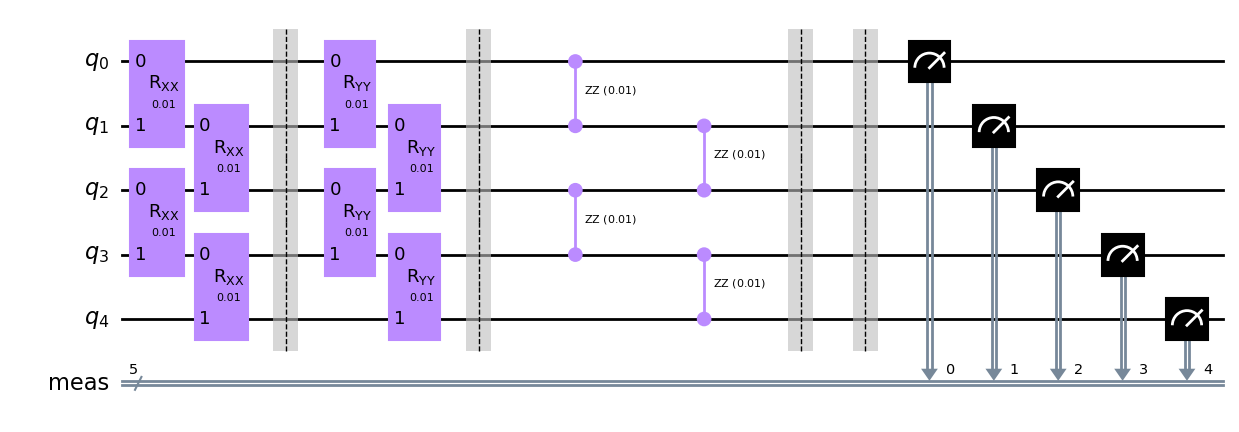

In [1711]:
circ[1].draw('mpl')

In [1713]:
with PdfPages(r'trotter_evo_for_Peter.pdf') as export_pdf:
    export_pdf.savefig(circ[1].draw('mpl'))

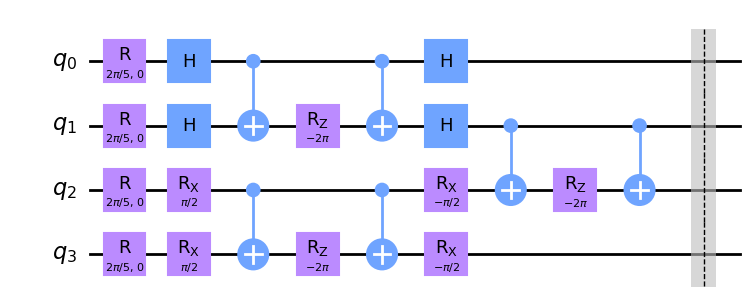

In [1714]:
qc = QuantumCircuit(4)
qc.rx(0.2 * 2 * np.pi, 0)
qc.rx(0.2 * 2 * np.pi, 1)
qc.rx(0.2 * 2 * np.pi, 2)
qc.rx(0.2 * 2 * np.pi, 3)
qc.rxx(-2 * np.pi, 0, 1)
qc.ryy(-2 * np.pi, 2, 3)
qc.rzz(-2 * np.pi, 1, 2)
qc.barrier()
qc.decompose().draw('mpl')

In [1180]:
trot_circ_2 = trotter_circuit_2q(1, 5, 0.05)

NameError: name 'trotter_circuit_2q' is not defined

In [1075]:
trot_circ_2[0].draw()

░ ┌─┐┌───┐
   q_0: ─░─┤M├┤ H ├
         ░ └╥┘└┬─┬┘
   q_1: ─░──╫──┤M├─
         ░  ║  └╥┘ 
meas: 2/════╩═══╩══
            0   1

In [232]:
150 * 9 /10

135.0

In [823]:
len(trotter_circuit(1,T,0.001))

1000

In [688]:
al, be, ga, de = 0.1, 0.1, 0.1, 1 - al - be - ga
p = pauli_error([(Pauli('X'), al),(Pauli('Y'), be),(Pauli('Z'), ga),(Pauli('I'), de)])

In [1468]:
cdict = {'XI':tensor(sigmax(), qeye(2)), 'YI':tensor(sigmay(), qeye(2)),
         'ZI':tensor(sigmaz(), qeye(2)), 'IX':tensor(qeye(2), sigmax()),
         'IY':tensor(qeye(2), sigmay()), 'IZ':tensor(qeye(2), sigmaz()),
         'II':tensor(qeye(2), qeye(2)), 'XX':tensor(sigmax(), sigmax()),
         'YY':tensor(sigmay(), sigmay()), 'ZZ':tensor(sigmaz(), sigmaz()),
         'XY':tensor(sigmax(), sigmay()), 'XZ':tensor(sigmax(), sigmaz()),
         'YX':tensor(sigmay(), sigmax()), 'YZ':tensor(sigmay(), sigmaz()),
         'ZX':tensor(sigmaz(), sigmax()), 'ZY':tensor(sigmaz(), sigmay())}

In [1871]:
kraus2q = Kraus([np.sqrt(a) * b for a,b in zip(probs, paulis)])

In [1952]:
paulis[0].T.conj()

array([[0.-0.j, 0.-0.j, 1.-0.j, 0.-0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, 1.-0.j],
       [1.-0.j, 0.-0.j, 0.-0.j, 0.-0.j],
       [0.-0.j, 1.-0.j, 0.-0.j, 0.-0.j]])

In [1906]:
chk2q_err = Kraus(error2q_all)

In [1928]:
chk3q_err = Kraus(k_list)

In [2060]:
c = 0.002
test = np.identity(4) - (1/2) * c * sum([np.zeros((4,4)) if key=='II' 
                else dit@dit.conj().T for dit, key in zip(paulis, cdict.keys())])

In [2061]:
test

array([[0.985+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.985+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.985+0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.   +0.j, 0.985+0.j]])

In [2031]:
k_list = [np.sqrt(np.identity(4) - c * sum([0 if key=='II' else dit.conj().T @ dit 
                    for dit, key in zip(paulis, cdict.keys())])) if
         key == 'II' else np.sqrt(c) * dit for dit, key in zip(paulis, cdict.keys())]

In [2070]:
Pauli('IX').to_matrix() @ Pauli('IX').inverse().to_matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [2063]:
sum([0 if key=='II' else dit 
                    for dit, key in zip(paulis, cdict.keys())])

array([[ 3.+0.j,  2.-2.j,  2.-2.j,  0.-2.j],
       [ 2.+2.j, -1.+0.j,  2.+0.j,  0.+0.j],
       [ 2.+2.j,  2.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+2.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [2032]:
sum([mat.conj().T @ mat for mat in k_list])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [2033]:
k_list[6].conj().T @ k_list[6]

array([[0.97+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.97+0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.97+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.97+0.j]])

In [2047]:
k2q_list = Kraus(k_list, (2,2), (2,2))

In [2057]:
kraus_error(k2q_list.data).circuits[0].draw()

┌────────┐
q_0: ┤0       ├
     │  kraus │
q_1: ┤1       ├
     └────────┘

In [1186]:
p_error_2q = 0.001
noise_model2q = NoiseModel()
# error = depolarizing_error(p_error, 1)
# error2q = depolarizing_error(p_error_2q, 2)
paulis = [Pauli(key) for key in cdict.keys()]
probs = [1 - (len(cdict)-1)*p_error_2q if key == 'II' else p_error_2q for key in cdict.keys()]
# error2q_all = pauli_error([(a, b) for a,b in zip(paulis, probs)])
error2q_all = pauli_error([(Pauli('X'), p_error_2q),(Pauli('Y'), p_error_2q),
                           (Pauli('Z'), p_error_2q),(Pauli('I'), 1 - 3*p_error_2q)])
error2q_final = error2q_all.tensor(error2q_all)
# noise_model.add_all_qubit_quantum_error(error_all,['u1', 'u2', 'u3'])
noise_model2q.add_all_qubit_quantum_error(error2q_all,['u1', 'u2', 'u3'])
# noise_model.add_all_qubit_quantum_error(error,['u1', 'u2', 'u3'])

In [2198]:
print(error2q_final)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(1) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Y ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(2) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(3) = 0.000997, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(4) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Y ├
     └───┘
  P(5) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Y ├
     ├───┤
q_1: ┤ Y ├
     └───┘
  P(6) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ Y ├
     └───┘
  P(7) = 0.000997, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Y ├
     └───┘
  P(8) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(9) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Y ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(10) = 1e-06, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(11) = 0.000997, Circuit = 
     ┌───┐
q_0: ┤ 

In [2183]:
qc.draw()

┌───┐
q_0: ─■───────┤ I ├
      │ZZ(2π) └───┘
q_1: ─■────────────

In [2116]:
print(noise_model2q)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [1181]:
def trotter_circuit_2q(h, T, dt):
    
    ''' Make the time evolution circuits (all X gates out to time T). '''

    times = np.linspace(0, T, int(1/dt))
    
    trot_out = []
    
    for t in times:
    
        qc = QuantumCircuit(2)
        
        for _ in range(int(t/dt)):
            # qc.rzz(2 * np.pi * h * dt, 0, 1)
            qc.rx(2 * np.pi * h * dt, 0)
            qc.rx(2 * np.pi * h * dt, 1)
            qc.barrier()
        
        # qc.h(0)
        # qc.h(1)
        qc.measure_all()
        
        trot_out.append(qc)
    
    return trot_out

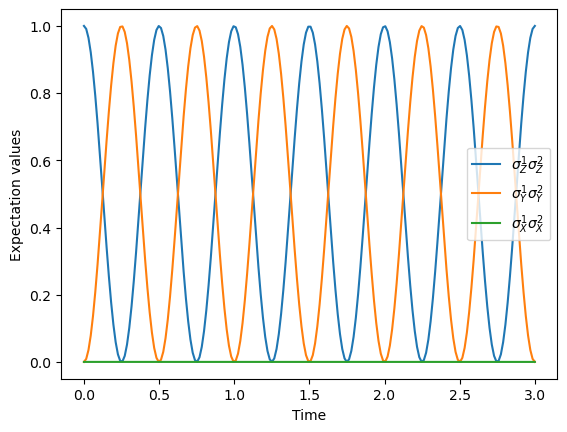

In [1182]:
''' The 2 qubit version. '''

times = np.linspace(0.0, 3.0, 200)

cdict = {'XI':tensor(sigmax(), qeye(2)), 'YI':tensor(sigmay(), qeye(2)),
         'ZI':tensor(sigmaz(), qeye(2)), 'IX':tensor(qeye(2), sigmax()),
         'IY':tensor(qeye(2), sigmay()), 'IZ':tensor(qeye(2), sigmaz()),
         'II':tensor(qeye(2), qeye(2)), 'XX':tensor(sigmax(), sigmax()),
         'YY':tensor(sigmay(), sigmay()), 'ZZ':tensor(sigmaz(), sigmaz()),
         'XY':tensor(sigmax(), sigmay()), 'XZ':tensor(sigmax(), sigmaz()),
         'YX':tensor(sigmay(), sigmax()), 'YZ':tensor(sigmay(), sigmaz()),
         'ZX':tensor(sigmaz(), sigmax()), 'ZY':tensor(sigmaz(), sigmay())}

H = 2 * np.pi * 0.5 * (cdict['XI'] + cdict['IX'])

psi0 = tensor(basis(2, 0), basis(2, 0))

# cofs_un = [1 for _ in range(len(cops))] # rnd.randint(1, len(cops))

# x = 0.001
cofs = [0 if key == 'II' else 0.6 for key in cdict.keys()]

# for a, key in zip(cofs, cdict.keys()):
#     H += a * cdict[key]

result_ = mesolve(H, psi0, times, [], [cdict['ZZ'], cdict['YY'], cdict['XX']])

fig, ax = plt.subplots()

ax.plot(result_.times, result_.expect[0]);

ax.plot(result_.times, result_.expect[1]);

ax.plot(result_.times, result_.expect[2]);

ax.set_xlabel('Time');

ax.set_ylabel('Expectation values');

ax.legend((r"$\sigma_Z^1\sigma_Z^2$", 
           r"$\sigma_Y^1\sigma_Y^2$", 
           r"$\sigma_X^1\sigma_X^2$"));

plt.show(fig)

In [1183]:
print(error2q_final)

NameError: name 'error2q_final' is not defined

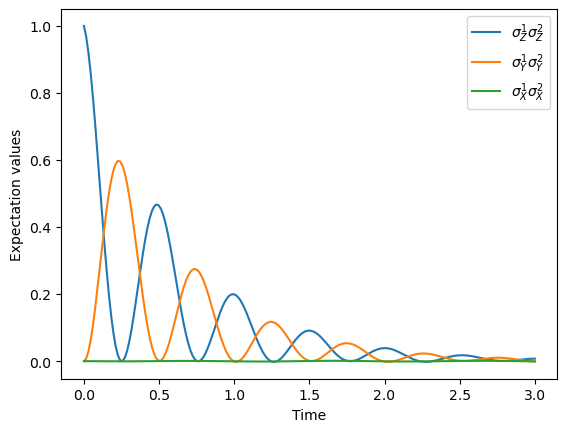

In [1184]:
''' The 2 qubit version. '''

times = np.linspace(0.0, 3.0, 200)

psi0 = tensor(basis(2, 0), basis(2, 0))

cdict = {'XI':tensor(sigmax(), qeye(2)), 'YI':tensor(sigmay(), qeye(2)),
         'ZI':tensor(sigmaz(), qeye(2)), 'IX':tensor(qeye(2), sigmax()),
         'IY':tensor(qeye(2), sigmay()), 'IZ':tensor(qeye(2), sigmaz()),
         'II':tensor(qeye(2), qeye(2)), 'XX':tensor(sigmax(), sigmax()),
         'YY':tensor(sigmay(), sigmay()), 'ZZ':tensor(sigmaz(), sigmaz()),
         'XY':tensor(sigmax(), sigmay()), 'XZ':tensor(sigmax(), sigmaz()),
         'YX':tensor(sigmay(), sigmax()), 'YZ':tensor(sigmay(), sigmaz()),
         'ZX':tensor(sigmaz(), sigmax()), 'ZY':tensor(sigmaz(), sigmay())}

H = 2 * np.pi * 0.5 * (cdict['XI'] + cdict['IX']) # (cdict['ZZ'])

# cops = [cdict[key] for key in cdict.keys()]
# cops = [cdict['XI'], cdict['YI'], cdict['ZI'], cdict['IX'], cdict['IY'], cdict['IZ'],
#         cdict['XY'], cdict['YX'], cdict['YZ'], cdict['ZY'], cdict['XZ'], cdict['ZX'],
#         cdict['XX'], cdict['YY'], cdict['ZZ']]

cops = [cdict['XI'], cdict['YI'], cdict['ZI'],
        cdict['XX'], cdict['ZZ'], cdict['YY'],
        cdict['XY'], cdict['YZ'], cdict['XZ']]

# cofs_un = [1 for _ in range(len(cops))] # rnd.randint(1, len(cops))

# cofs = [el/sum(cofs_un) for el in cofs_un]

x = 0
# cofs = [x if key == 'II' else 0.6 for key in cdict.keys()]
cofs = [0.63, 0.63, 0.63, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006]

# y = 0.62
# cofs = [y for _ in cops]

resultP = mesolve(H, psi0, times, [[co * op for co, op in zip(cofs, cops)]],
                 [cdict['ZZ'], cdict['YY'], cdict['XX']])

fig, ax = plt.subplots()

ax.plot(resultP.times, resultP.expect[0]);

ax.plot(resultP.times, resultP.expect[1]);

ax.plot(resultP.times, resultP.expect[2]);

# ax.plot(resultP.times, [0.33 for _ in range(len(resultP.times))], linewidth=0.5);

ax.set_xlabel('Time');

ax.set_ylabel('Expectation values');

ax.legend((r"$\sigma_Z^1\sigma_Z^2$", 
           r"$\sigma_Y^1\sigma_Y^2$", 
           r"$\sigma_X^1\sigma_X^2$"));

plt.show(fig)

See about inverting Kraus error. Mabye via the Kraus class, or possibly in the krause_noise() function.

In [2140]:
rho = steadystate(H, cops, method='direct').tidyup(atol=1e-15)

In [2141]:
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]

In [2142]:
np.trace(Pauli('ZZ').to_matrix() @ np.array(rho))

(1.1102230246251565e-16+0j)

In [1187]:
''' Run it with QASM: 2 qubits. '''

T = 3
    
shots = 8192

# back = Aer.get_backend('aer_simulator', noise_model = noise_model)
back2q = AerSimulator(noise_model=noise_model2q)
# device_backend = FakeSantiago()
# back = Aer.get_backend('aer_simulator')
# back = AerSimulator.from_backend(device_backend)

circs2q = trotter_circuit_2q(1, T, 0.005)
circ_tnoise2q = [qiskit.transpile(circ, back2q) for circ in circs2q]

run_circs2q = qiskit.execute(circ_tnoise2q, back2q,
                           shots=shots, initial_layout=[0,1])
    

In [2137]:
circ_tnoise2q[1].draw()

┌────────────────────┐ ░ ┌────────────────────┐ ░ »
   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
        ├────────────────────┤ ░ ├────────────────────┤ ░ »
   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
        └────────────────────┘ ░ └────────────────────┘ ░ »
meas: 2/══════════════════════════════════════════════════»
                                                          »
«        ┌────────────────────┐ ░  ░ ┌─┐   
«   q_0: ┤ U3(π/100,-π/2,π/2) ├─░──░─┤M├───
«        ├────────────────────┤ ░  ░ └╥┘┌─┐
«   q_1: ┤ U3(π/100,-π/2,π/2) ├─░──░──╫─┤M├
«        └────────────────────┘ ░  ░  ║ └╥┘
«meas: 2/═════════════════════════════╩══╩═
«                                     0  1

In [1188]:
sim_out_q2 = run_circs2q.result()

res2q = []
for count in sim_out_q2.get_counts():
    if count.get('00') is None:
        count['00'] = 0.0
    if count.get('11') is None:
        count['11'] = 0.0
    if count.get('01') is None:
        count['01'] = 0.0
    if count.get('10') is None:
        count['10'] = 0.0
    # res.append(2*(count['00 00']/shots) - 1)
    res2q.append(2*(count['00']/shots + count['11']/shots) - 1)

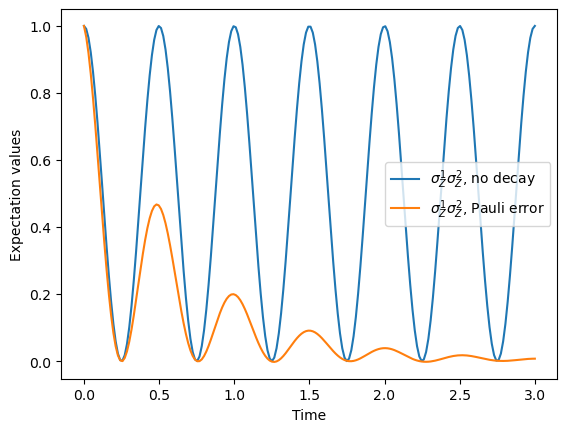

In [1189]:
fig, ax = plt.subplots()

ax.plot(result_.times, result_.expect[0]);

ax.plot(resultP.times, resultP.expect[0]);

ax.set_xlabel('Time');

ax.set_ylabel('Expectation values');

ax.legend((r"$\sigma_Z^1\sigma_Z^2$, no decay",
          r"$\sigma_Z^1\sigma_Z^2$, Pauli error"));

plt.show(fig)

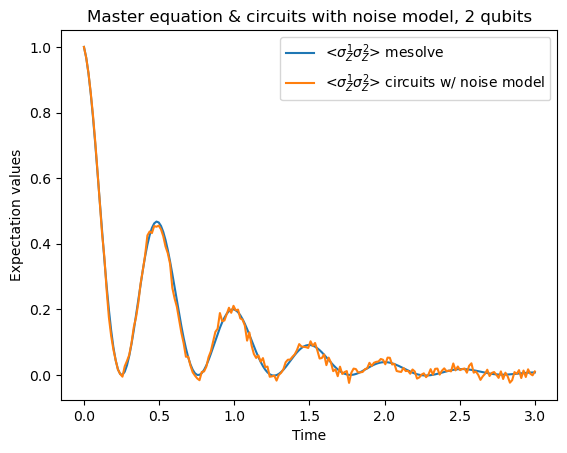

In [1190]:
fig, ax = plt.subplots()

ax.plot(resultP.times, resultP.expect[0], label=r'<$\sigma_Z^1\sigma_Z^2$> mesolve');

ax.plot(times, res2q, label=r'<$\sigma_Z^1\sigma_Z^2$> circuits w/ noise model');

ax.set_xlabel('Time');

ax.set_ylabel('Expectation values');

ax.set_title('Master equation & circuits with noise model, 2 qubits')

ax.legend();

plt.show()

In [1814]:
attempt = Kraus([np.sqrt(0.002)*Pauli('X').to_matrix(), 
          np.sqrt(0.002)*Pauli('Y').to_matrix(), 
          np.sqrt(0.002)*Pauli('Z').to_matrix(),
           np.sqrt(1 - 3*0.002)*Pauli('I').to_matrix()])

In [1827]:
k_err2 = kraus_error(attempt.data)

In [1797]:
k_err = kraus_error(kraus)

In [1798]:
print(k_err)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


In [1707]:
hasattr(error_all, "to_quantumchannel")

True

In [ ]:
SuperOp()

In [1709]:
error_all.to_quantumchannel()

SuperOp([[0.996+0.j, 0.   +0.j, 0.   +0.j, 0.004+0.j],
         [0.   +0.j, 0.992+0.j, 0.   +0.j, 0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.992+0.j, 0.   +0.j],
         [0.004+0.j, 0.   +0.j, 0.   +0.j, 0.996+0.j]],
        input_dims=(2,), output_dims=(2,))

In [2143]:
error_all.circuits[0].draw()

┌───┐
q: ┤ X ├
   └───┘

In [1717]:
dim = 2 ** error_all.num_qubits

In [1719]:
ret = SuperOp(np.zeros([dim * dim, dim * dim]))

In [1734]:
SuperOp(error_all.circuits[2])

SuperOp([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]],
        input_dims=(2,), output_dims=(2,))

In [1753]:
print(error_all.circuits[0].to_instruction())
print(error_all.circuits[1].to_instruction())
print(error_all.circuits[2].to_instruction())
print(error_all.circuits[3].to_instruction())

Instruction(name='circuit-34962790', num_qubits=1, num_clbits=0, params=[])
Instruction(name='circuit-34962791', num_qubits=1, num_clbits=0, params=[])
Instruction(name='circuit-34962792', num_qubits=1, num_clbits=0, params=[])
Instruction(name='circuit-34962793', num_qubits=1, num_clbits=0, params=[])


In [1781]:
error_all.circuits[1].to_instruction().name

'circuit-34962791'

In [1758]:
op = SuperOp(np.eye(4**error_all.circuits[3].to_instruction().num_qubits))
op._append_instruction(error_all.circuits[3].to_instruction())
op

SuperOp([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
        input_dims=(2,), output_dims=(2,))

In [1782]:
for circ, prob in zip(error_all.circuits, error_all.probabilities):
    component = prob * SuperOp(circ)
    ret = ret + component

In [1783]:
ret

SuperOp([[0.996+0.j, 0.   +0.j, 0.   +0.j, 0.004+0.j],
         [0.   +0.j, 0.992+0.j, 0.   +0.j, 0.   +0.j],
         [0.   +0.j, 0.   +0.j, 0.992+0.j, 0.   +0.j],
         [0.004+0.j, 0.   +0.j, 0.   +0.j, 0.996+0.j]],
        input_dims=(2,), output_dims=(2,))

In [1716]:
error_all.circuits

In [1612]:
one = Kraus._init_transformer(error_all)

In [1784]:
one._data

array([[0.996+0.j, 0.   +0.j, 0.   +0.j, 0.004+0.j],
       [0.   +0.j, 0.992+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.992+0.j, 0.   +0.j],
       [0.004+0.j, 0.   +0.j, 0.   +0.j, 0.996+0.j]])

In [1615]:
op_shape = one._op_shape

In [1617]:
output_dim, input_dim = op_shape.shape

In [1636]:
shape = (output_dim, output_dim, input_dim, input_dim)

In [1788]:
# Now that the input is an operator we convert it to a Kraus
rep = getattr(one, "_channel_rep", "Operator")

In [1627]:
kraus = _to_kraus(rep, one._data, input_dim, output_dim)

In [1640]:
one.data

array([[0.996+0.j, 0.   +0.j, 0.   +0.j, 0.004+0.j],
       [0.   +0.j, 0.992+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.992+0.j, 0.   +0.j],
       [0.004+0.j, 0.   +0.j, 0.   +0.j, 0.996+0.j]])

In [1641]:
two = np.reshape(
        np.transpose(np.reshape(one.data, shape), (3, 1, 2, 0)),
        (shape[3] * shape[1], shape[0] * shape[2]))

In [1649]:
three = _choi_to_kraus(two, input_dim, output_dim)

In [1659]:
is_hermitian_matrix(two)

True

In [1661]:
w, v = la.schur(two, output="complex")
print(w)
print(v)

[[1.988+0.j 0.   +0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.004+0.j 0.   +0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.004+0.j 0.   +0.j]
 [0.   +0.j 0.   +0.j 0.   +0.j 0.004+0.j]]
[[-0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [-0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]]


In [1662]:
w = w.diagonal().real
w

array([1.988, 0.004, 0.004, 0.004])

In [1680]:
w[w > 0]

array([1.988, 0.004, 0.004, 0.004])

In [1684]:
for val, vec in zip(w, v.T):
    print(val)
    print(vec)

1.987999999999999
[-0.70710678+0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
0.003999999999999985
[-0.70710678+0.j  0.        +0.j  0.        +0.j  0.70710678+0.j]
0.004
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
0.004
[0.+0.j 0.+0.j 1.+0.j 0.+0.j]


In [1701]:
two

array([[0.996+0.j, 0.   +0.j, 0.   +0.j, 0.992+0.j],
       [0.   +0.j, 0.004+0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.   +0.j, 0.004+0.j, 0.   +0.j],
       [0.992+0.j, 0.   +0.j, 0.   +0.j, 0.996+0.j]])

In [1792]:
v.T[0].reshape((output_dim, input_dim), order="F")

array([[-0.70710678+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.70710678+0.j]])

In [1665]:
if len(w[w < 0]) == 0:
    # CP-map Kraus representation
    kraus = []
    for val, vec in zip(w, v.T):
        if abs(val) > 0:
            k = np.sqrt(val) * vec.reshape((output_dim, input_dim), order="F")
            kraus.append(k)
    # If we are converting a zero matrix, we need to return a Kraus set
    # with a single zero-element Kraus matrix
    if not kraus:
        kraus.append(np.zeros((output_dim, input_dim), dtype=complex))

print(kraus)

[array([[-0.99699549+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.99699549+0.j]]), array([[-0.04472136+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.04472136+0.j]]), array([[0.        +0.j, 0.        +0.j],
       [0.06324555+0.j, 0.        +0.j]]), array([[0.        +0.j, 0.06324555+0.j],
       [0.        +0.j, 0.        +0.j]])]


In [1584]:
kops = Kraus(error_all)

In [1594]:
kops.data

[array([[-0.99699549+0.j,  0.        +0.j],
        [ 0.        +0.j, -0.99699549+0.j]]),
 array([[-0.04472136+0.j,  0.        +0.j],
        [ 0.        +0.j,  0.04472136+0.j]]),
 array([[0.        +0.j, 0.        +0.j],
        [0.06324555+0.j, 0.        +0.j]]),
 array([[0.        +0.j, 0.06324555+0.j],
        [0.        +0.j, 0.        +0.j]])]

In [1502]:
liouvillian(H)

Quantum object: dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape = (16, 16), type = super, isherm = False
Qobj data =
[[0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.+6.28318531j 0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.+0.j         0.+6.28318531j 0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.+0.j         0.+0.j     

In [2135]:
psi0.proj()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [1515]:
Qobj(psi0.full() @ psi0.full().T)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [1538]:
expand_operator(sigmax(), 2, 0)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

In [1546]:
one = sprepost(expand_operator(qeye(2), 2, 0), expand_operator(qeye(2), 2, 0))

In [1547]:
two = spre(expand_operator(qeye(2), 2, 0) * expand_operator(qeye(2), 2, 0).dag())

In [1548]:
three = spost(expand_operator(qeye(2), 2, 0) * expand_operator(qeye(2), 2, 0).dag())

In [1549]:
one - (0.5)*two - (0.5)*three

Quantum object: dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]], shape = (16, 16), type = super, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [871]:
num = 1

In [1078]:
circs[num].draw()

┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ »
  q: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
     └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ »
c: 1/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ »
«  q: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
«     └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ »
«c: 1/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌───────────┐ ░ ┌───────────┐ ░ ┌─┐
«  q: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤M├
«     └───────────┘ ░ └───────────┘ ░ └╥┘
«c: 1/═════════════════════════════════╩═
«                                      0

In [1079]:
circ_tnoise[num].draw()

┌────────────────────┐ ░ ┌────────────────────┐ ░ ┌────────────────────┐»
  q: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├»
     └────────────────────┘ ░ └────────────────────┘ ░ └────────────────────┘»
c: 1/════════════════════════════════════════════════════════════════════════»
                                                                             »
«      ░ ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«  q: ─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«      ░ └────────────────────┘ ░ └────────────────────┘ ░ »
«c: 1/═════════════════════════════════════════════════════»
«                                                          »
«     ┌────────────────────┐ ░ ┌────────────────────┐ ░ ┌────────────────────┐»
«  q: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├»
«     └────────────────────┘ ░ └────────────────────┘ ░ └────────────────────┘»
«c: 1/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ░ ┌────────────────────┐ ░ ┌────────────────────┐ ░ ┌─┐
«  q: ─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─┤M├
«      ░ └────────────────────┘ ░ └────────────────────┘ ░ └╥┘
«c: 1/══════════════════════════════════════════════════════╩═
«                                                           0

In [1080]:
circs2q[num].draw()

┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ »
   q_0: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
        ├───────────┤ ░ ├───────────┤ ░ ├───────────┤ ░ ├───────────┤ ░ »
   q_1: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
        └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ »
meas: 2/════════════════════════════════════════════════════════════════»
                                                                        »
«        ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ ┌───────────┐ ░ »
«   q_0: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
«        ├───────────┤ ░ ├───────────┤ ░ ├───────────┤ ░ ├───────────┤ ░ »
«   q_1: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─»
«        └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ └───────────┘ ░ »
«meas: 2/════════════════════════════════════════════════════════════════»
«                                                                        »
«        ┌───────────┐ ░ ┌───────────┐ ░ ┌───┐ ░ ┌─┐   
«   q_0: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ H ├─░─┤M├───
«        ├───────────┤ ░ ├───────────┤ ░ ├───┤ ░ └╥┘┌─┐
«   q_1: ┤ Rx(π/100) ├─░─┤ Rx(π/100) ├─░─┤ H ├─░──╫─┤M├
«        └───────────┘ ░ └───────────┘ ░ └───┘ ░  ║ └╥┘
«meas: 2/═════════════════════════════════════════╩══╩═
«                                                 0  1

In [1081]:
circ_tnoise2q[num].draw()

┌────────────────────┐ ░ ┌────────────────────┐ ░ »
   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
        ├────────────────────┤ ░ ├────────────────────┤ ░ »
   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
        └────────────────────┘ ░ └────────────────────┘ ░ »
meas: 2/══════════════════════════════════════════════════»
                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        ├────────────────────┤ ░ ├────────────────────┤ ░ »
«   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        └────────────────────┘ ░ └────────────────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════»
«                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        ├────────────────────┤ ░ ├────────────────────┤ ░ »
«   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        └────────────────────┘ ░ └────────────────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════»
«                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ »
«   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        ├────────────────────┤ ░ ├────────────────────┤ ░ »
«   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─»
«        └────────────────────┘ ░ └────────────────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════»
«                                                          »
«        ┌────────────────────┐ ░ ┌────────────────────┐ ░ ┌─────────┐ ░ ┌─┐   
«   q_0: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U2(0,π) ├─░─┤M├───
«        ├────────────────────┤ ░ ├────────────────────┤ ░ ├─────────┤ ░ └╥┘┌─┐
«   q_1: ┤ U3(π/100,-π/2,π/2) ├─░─┤ U3(π/100,-π/2,π/2) ├─░─┤ U2(0,π) ├─░──╫─┤M├
«        └────────────────────┘ ░ └────────────────────┘ ░ └─────────┘ ░  ║ └╥┘
«meas: 2/═════════════════════════════════════════════════════════════════╩══╩═
«                                                                         0  1

In [1041]:
run_circs2q.result().get_counts()

[{'00': 8192},
 {'01': 207, '11': 5, '10': 186, '00': 7794},
 {'01': 681, '11': 67, '10': 722, '00': 6722},
 {'01': 1340, '10': 1353, '11': 360, '00': 5139},
 {'01': 1884, '10': 1842, '11': 956, '00': 3510},
 {'01': 2037, '10': 1986, '11': 2063, '00': 2106},
 {'01': 1875, '10': 1765, '11': 3513, '00': 1039},
 {'01': 1332, '00': 345, '10': 1320, '11': 5195},
 {'01': 702, '10': 715, '00': 67, '11': 6708},
 {'00': 9, '10': 206, '11': 7782, '01': 195},
 {'11': 8192},
 {'01': 199, '00': 5, '10': 200, '11': 7788},
 {'01': 697, '00': 80, '10': 722, '11': 6693},
 {'01': 1398, '10': 1392, '00': 331, '11': 5071},
 {'01': 1849, '11': 3497, '00': 955, '10': 1891},
 {'01': 2056, '11': 2034, '00': 2086, '10': 2016},
 {'01': 1832, '11': 977, '00': 3515, '10': 1868},
 {'01': 1350, '11': 366, '00': 5141, '10': 1335},
 {'01': 696, '11': 74, '10': 691, '00': 6731},
 {'01': 207, '11': 3, '10': 193, '00': 7789},
 {'01': 1, '10': 1, '00': 8190},
 {'01': 256, '11': 7, '10': 233, '00': 7696},
 {'01': 771, '11

In [1158]:
len(res)

200

In [1083]:
res2q

[0.001708984375,
 0.00537109375,
 0.009765625,
 0.01806640625,
 -0.007568359375,
 0.01611328125,
 0.001220703125,
 0.0107421875,
 0.010498046875,
 -0.0087890625,
 0.0029296875,
 0.00146484375,
 0.0166015625,
 -0.0068359375,
 0.0,
 -0.01220703125,
 0.005615234375,
 0.001220703125,
 0.0087890625,
 -0.007080078125,
 0.001708984375,
 0.004150390625,
 0.010986328125,
 -0.00146484375,
 0.026611328125,
 -0.005859375,
 -0.016357421875,
 0.007080078125,
 0.002197265625,
 -0.01708984375,
 0.00537109375,
 0.01171875,
 0.0087890625,
 0.015625,
 0.006103515625,
 0.01220703125,
 0.003173828125,
 0.004150390625,
 0.008056640625,
 -0.00537109375,
 -0.00732421875,
 -0.01318359375,
 -0.016845703125,
 -0.010986328125,
 0.021240234375,
 0.002197265625,
 -0.00634765625,
 0.00146484375,
 -0.000244140625,
 0.007568359375,
 0.01953125,
 -0.0078125,
 -0.0087890625,
 0.015380859375,
 0.00048828125,
 -0.0009765625,
 0.000732421875,
 0.01220703125,
 0.0244140625,
 -0.020263671875,
 -0.0166015625,
 -0.02197265625,

In [988]:
res

[1.0,
 0.948486328125,
 0.8216552734375,
 0.6365966796875,
 0.42333984375,
 0.246826171875,
 0.1236572265625,
 0.0435791015625,
 0.010009765625,
 0.00048828125,
 0,
 0.0006103515625,
 0.0101318359375,
 0.0421142578125,
 0.115966796875,
 0.248291015625,
 0.4234619140625,
 0.6334228515625,
 0.8162841796875,
 0.9537353515625,
 0.9996337890625,
 0.942626953125,
 0.7958984375,
 0.61767578125,
 0.4105224609375,
 0.2347412109375,
 0.1041259765625,
 0.0419921875,
 0.0079345703125,
 0.000732421875,
 0,
 0.0009765625,
 0.0111083984375,
 0.0484619140625,
 0.133056640625,
 0.2679443359375,
 0.4459228515625,
 0.6588134765625,
 0.8287353515625,
 0.96044921875,
 0.9976806640625,
 0.9293212890625,
 0.7830810546875,
 0.59814453125,
 0.38671875,
 0.2236328125,
 0.1025390625,
 0.03662109375,
 0.005615234375,
 0.000244140625,
 0,
 0.00146484375,
 0.01220703125,
 0.05322265625,
 0.142333984375,
 0.285400390625,
 0.4635009765625,
 0.6715087890625,
 0.8525390625,
 0.9683837890625,
 0.994140625,
 0.9182128906

In [318]:
def Trotter_SV(state, # The initial state to evolve
            t, # Total evolution times
            n, # The number of break ups
           ):
    
    dt = t/n
    
    ops_exp = Qobj(-1j*2*np.pi*dt*sigmax()).expm()
    
    out_state = state
    for _ in range(int(n)):
        
        out_state = ops_exp * out_state
            
    return out_state

In [410]:
in_state = basis(2,0)

times = np.linspace(0.01, 10, 1000)
nn = [150*i/10 for i in times]

out = []
for t,n in zip(times,nn):
    
    out.append(Trotter_SV(in_state, t, n))
    
res = []
for st in out:
    res.append(np.real(st.overlap(sigmaz()*st)))

In [1070]:
times = np.linspace(0, 10, 200)

In [844]:
times

array([ 0.        ,  0.05025126,  0.10050251,  0.15075377,  0.20100503,
        0.25125628,  0.30150754,  0.35175879,  0.40201005,  0.45226131,
        0.50251256,  0.55276382,  0.60301508,  0.65326633,  0.70351759,
        0.75376884,  0.8040201 ,  0.85427136,  0.90452261,  0.95477387,
        1.00502513,  1.05527638,  1.10552764,  1.15577889,  1.20603015,
        1.25628141,  1.30653266,  1.35678392,  1.40703518,  1.45728643,
        1.50753769,  1.55778894,  1.6080402 ,  1.65829146,  1.70854271,
        1.75879397,  1.80904523,  1.85929648,  1.90954774,  1.95979899,
        2.01005025,  2.06030151,  2.11055276,  2.16080402,  2.21105528,
        2.26130653,  2.31155779,  2.36180905,  2.4120603 ,  2.46231156,
        2.51256281,  2.56281407,  2.61306533,  2.66331658,  2.71356784,
        2.7638191 ,  2.81407035,  2.86432161,  2.91457286,  2.96482412,
        3.01507538,  3.06532663,  3.11557789,  3.16582915,  3.2160804 ,
        3.26633166,  3.31658291,  3.36683417,  3.41708543,  3.46

In [1087]:
with PdfPages(r'noise_model_2qd_XX.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [554]:
qc.draw()

┌─────────┐┌─┐ ░ 
  q: ┤ Rx(π/5) ├┤M├─░─
     └─────────┘└╥┘ ░ 
c: 1/════════════╩════
                 0

In [558]:
qc_supOp = QuantumCircuit(1)
qc_supOp.rx(2 * np.pi * dt, 0)
qc_supOp.draw()

┌─────────┐
q: ┤ Rx(π/5) ├
   └─────────┘

In [ ]:
qc_sup

In [559]:
qc_supOp.save_superop()

In [661]:
noisy_simulator = AerSimulator(method = 'superop', noise_model = noise_model)

In [662]:
result = noisy_simulator.run(qc_supOp).result()
super_op_array = result.data()['superop']

In [663]:
Qobj(np.array(super_op_array))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.9045085+0.j         0.       -0.29389263j 0.       +0.29389263j
  0.0954915+0.j        ]
 [0.       -0.29389263j 0.9045085+0.j         0.0954915+0.j
  0.       +0.29389263j]
 [0.       +0.29389263j 0.0954915+0.j         0.9045085+0.j
  0.       -0.29389263j]
 [0.0954915+0.j         0.       +0.29389263j 0.       -0.29389263j
  0.9045085+0.j        ]]

In [590]:
Kraus(np.array(sigmax()))

Kraus([[[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]],
      input_dims=(2,), output_dims=(2,))

In [575]:
kos = super_op_array.to_instruction()

In [584]:
kos.params[0]

array([[-9.51056516e-01-3.23907708e-17j,  7.14593904e-19+3.09016994e-01j],
       [-1.29674062e-16+3.09016994e-01j, -9.51056516e-01+3.17221068e-17j]])

In [668]:
p.to_quantumchannel()

SuperOp([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
        input_dims=(2,), output_dims=(2,))

In [629]:
p_kraus = Kraus(p)
p_kraus
# Use .data to get the operators out.

Kraus([[[0.70710678+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j]],

       [[0.        +0.j, 0.        +0.j],
        [0.70710678+0.j, 0.        +0.j]],

       [[0.        +0.j, 0.70710678+0.j],
        [0.        +0.j, 0.        +0.j]],

       [[0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.70710678+0.j]]],
      input_dims=(2,), output_dims=(2,))

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [631]:
p_supOp = SuperOp(p)
p_supOp

SuperOp([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
        input_dims=(2,), output_dims=(2,))

In [431]:
noise_model = NoiseModel.from_backend(back)

In [435]:
noise_dict = noise_model.to_dict

In [521]:
kSp = noise_dict(0)['errors'][0]['instructions'][0][1]['params'][2]

In [542]:
kID = noise_dict(0)['errors'][0]['instructions'][0][1]['params']

In [548]:
print(kID[0])
print(kID[1])
print(kID[2])

[[-0.99999037+0.j  0.        +0.j]
 [ 0.        +0.j -0.99975255+0.j]]
[[-0.0043883 +0.j  0.        +0.j]
 [ 0.        +0.j  0.00438934+0.j]]
[[0.        +0.j 0.02180778+0.j]
 [0.        +0.j 0.        +0.j]]


In [523]:
kSp

array([[0.        +0.j, 0.02180778+0.j],
       [0.        +0.j, 0.        +0.j]])

In [539]:
A = (0.02180778/2) * (sigmax() + 1j*sigmay())

In [537]:
Adag = (0.02180778/2) * (sigmax() - 1j*sigmay())

In [541]:
Adag

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.         0.        ]
 [0.02180778 0.        ]]

In [456]:
noise_model.basis_gates

['cx',
 'for_loop',
 'id',
 'if_else',
 'kraus',
 'qerror_loc',
 'quantum_channel',
 'roerror',
 'rz',
 'save_amplitudes',
 'save_amplitudes_sq',
 'save_clifford',
 'save_density_matrix',
 'save_expval',
 'save_expval_var',
 'save_matrix_product_state',
 'save_probabilities',
 'save_probabilities_dict',
 'save_stabilizer',
 'save_state',
 'save_statevector',
 'save_statevector_dict',
 'save_superop',
 'save_unitary',
 'set_density_matrix',
 'set_matrix_product_state',
 'set_stabilizer',
 'set_statevector',
 'set_superop',
 'set_unitary',
 'superop',
 'sx',
 'while_loop',
 'x']

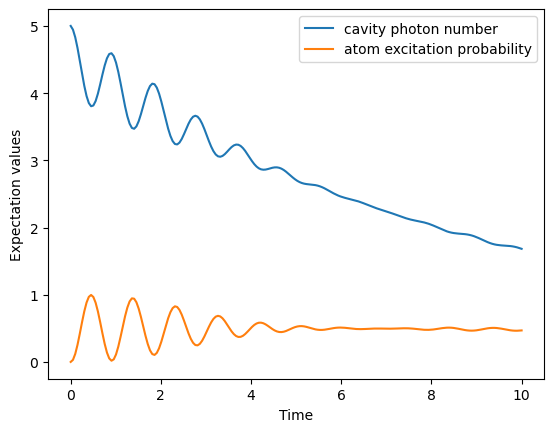

In [69]:
times = np.linspace(0.0, 10.0, 200)

psi0 = tensor(fock(2,0), fock(10, 5))

a  = tensor(qeye(2), destroy(10))

sm = tensor(destroy(2), qeye(10))

H = (2 * np.pi * a.dag() * a + 2 * np.pi * sm.dag() * sm 
     + 2 * np.pi * 0.25 * (sm * a.dag() + sm.dag() * a))

result = mesolve(H, psi0, times, [np.sqrt(0.1)*a], [a.dag()*a, sm.dag()*sm])

fig, ax = plt.subplots()

ax.plot(times, result.expect[0])

ax.plot(times, result.expect[1])

ax.set_xlabel('Time')

ax.set_ylabel('Expectation values')

ax.legend(("cavity photon number", "atom excitation probability"))

plt.show()

In [73]:
basis(2,0).overlap((qeye(2) + sigmax() + sigmay() + sigmaz())/2 * basis(2,0))

(1+0j)